# Problem 3: Introduction to ``JAGS``

In this notebook, we will use ``JAGS`` to perform Bayesian inference. ``JAGS`` stands for "Just Another Gibbs Sampler" and is a widely used implementation of the MCMC algorithm Gibbs sampling. Therefore, ``JAGS`` only works through sampling: all output obtained will be samples from the distribution of interest (usually the posterior distribution).

Remember that, if you are unable to load a package (e.g. ``library("MASS")``), remember to install the required library ``install.packages()`` (e.g. ``install.packages("MASS")``).

### Notebook Settings

The following changes the default plot size for the notebook:

In [1]:
options(repr.plot.width = 6, repr.plot.height = 4)

### Loading Libraries

The following loads the required packages to run all the code in this notebook:

In [3]:
# install.packages(c("rjags", "coda", "ggmcmc")) 
# install.packages(c("tidyverse", "cowplot"))

library(rjags)
library(coda)
library(ggmcmc)

library(tidyverse)
library(cowplot)
library(magrittr)

## What is a ``JAGS`` Program?

To call ``JAGS`` we need to supply ``rjags`` with a  ``JAGS`` program. A ``JAGS`` program is a file that fully specifies our particular Bayesian inference problem - the likelihood and the prior. That is, we need to specify our probability model or likelihood for the observed data $y_1, \ldots, y_n$. Each $y_i$ is assumed to be a realisation from a corresponding $Y_i$:

$$ Y_i | \theta \sim \mathbb{P}_{\theta}.$$ 

We also need to specify our prior:

$$ \theta \sim \Pi. $$

When we have fully specified our inference problem in the format that ``JAGS`` expects, and upon supplying ``JAGS`` with your observed data, ``JAGS`` will do the rest of the work for us and provide us with samples from the posterior distribution. This specification of an inference problem in the correct format is called a ``JAGS`` program.

In summary, in order for ``JAGS`` to be run, we need to specify our likelihood and prior in a standard format and use a corresponding ``rjags`` command to instruct ``JAGS`` to run on our inference problem and supply ``JAGS`` with our data. 

## Writing a ``JAGS`` Program

The easiest way to write a ``JAGS`` program in ``R`` is as a string, although it is possible to use a separate ``.txt`` file too:

    "
    model{
        
    }
    "
A ``JAGS`` program is always enclosed within curly braces ``{`` and ``}`` and preceded with the keyword ``model``. 

### Variables

Within a ``JAGS`` program you are able to specify both random and deterministic variables. The syntax is intended to directly reflect our math notation:
- Random variables are assigned using the operator ``~`` (note how this directly reflects the math notation $Y\sim\mathbb{P}$). For example ``y ~ dnorm(0,1)`` is equivalent to writing $Y\sim\mathcal{N}(0,1).$
- Deterministic relations are written using the operator ``<-``. For example `` x <- 0.2 ``. 

Deterministic relations don't necessarily have to be deterministic quantities. For instance, have a guess what is going on in the following ``JAGS`` program:

In [4]:
jags_model_string_1 <-  "
    model{
        X ~ dnorm(0,1)
        Y <- X + 2
    }
    "

That's right, $Y \sim \mathcal{N}(2,1)$ and so is random. However, it is called a "deterministic relation", since $Y | X=x$ takes the value $x + 2$ with probability $1$. Since ``JAGS`` only operates with sampling, running this program for $1000$ samples means that we will only sample $1000$ times from $X$ and the samples obtained from $Y$ are just the $X$ samples with $2$ added to them.

Let's run this ``JAGS`` program for $1000$ samples and check the output to confirm:

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 0
   Unobserved stochastic nodes: 1
   Total graph size: 5

Initializing model



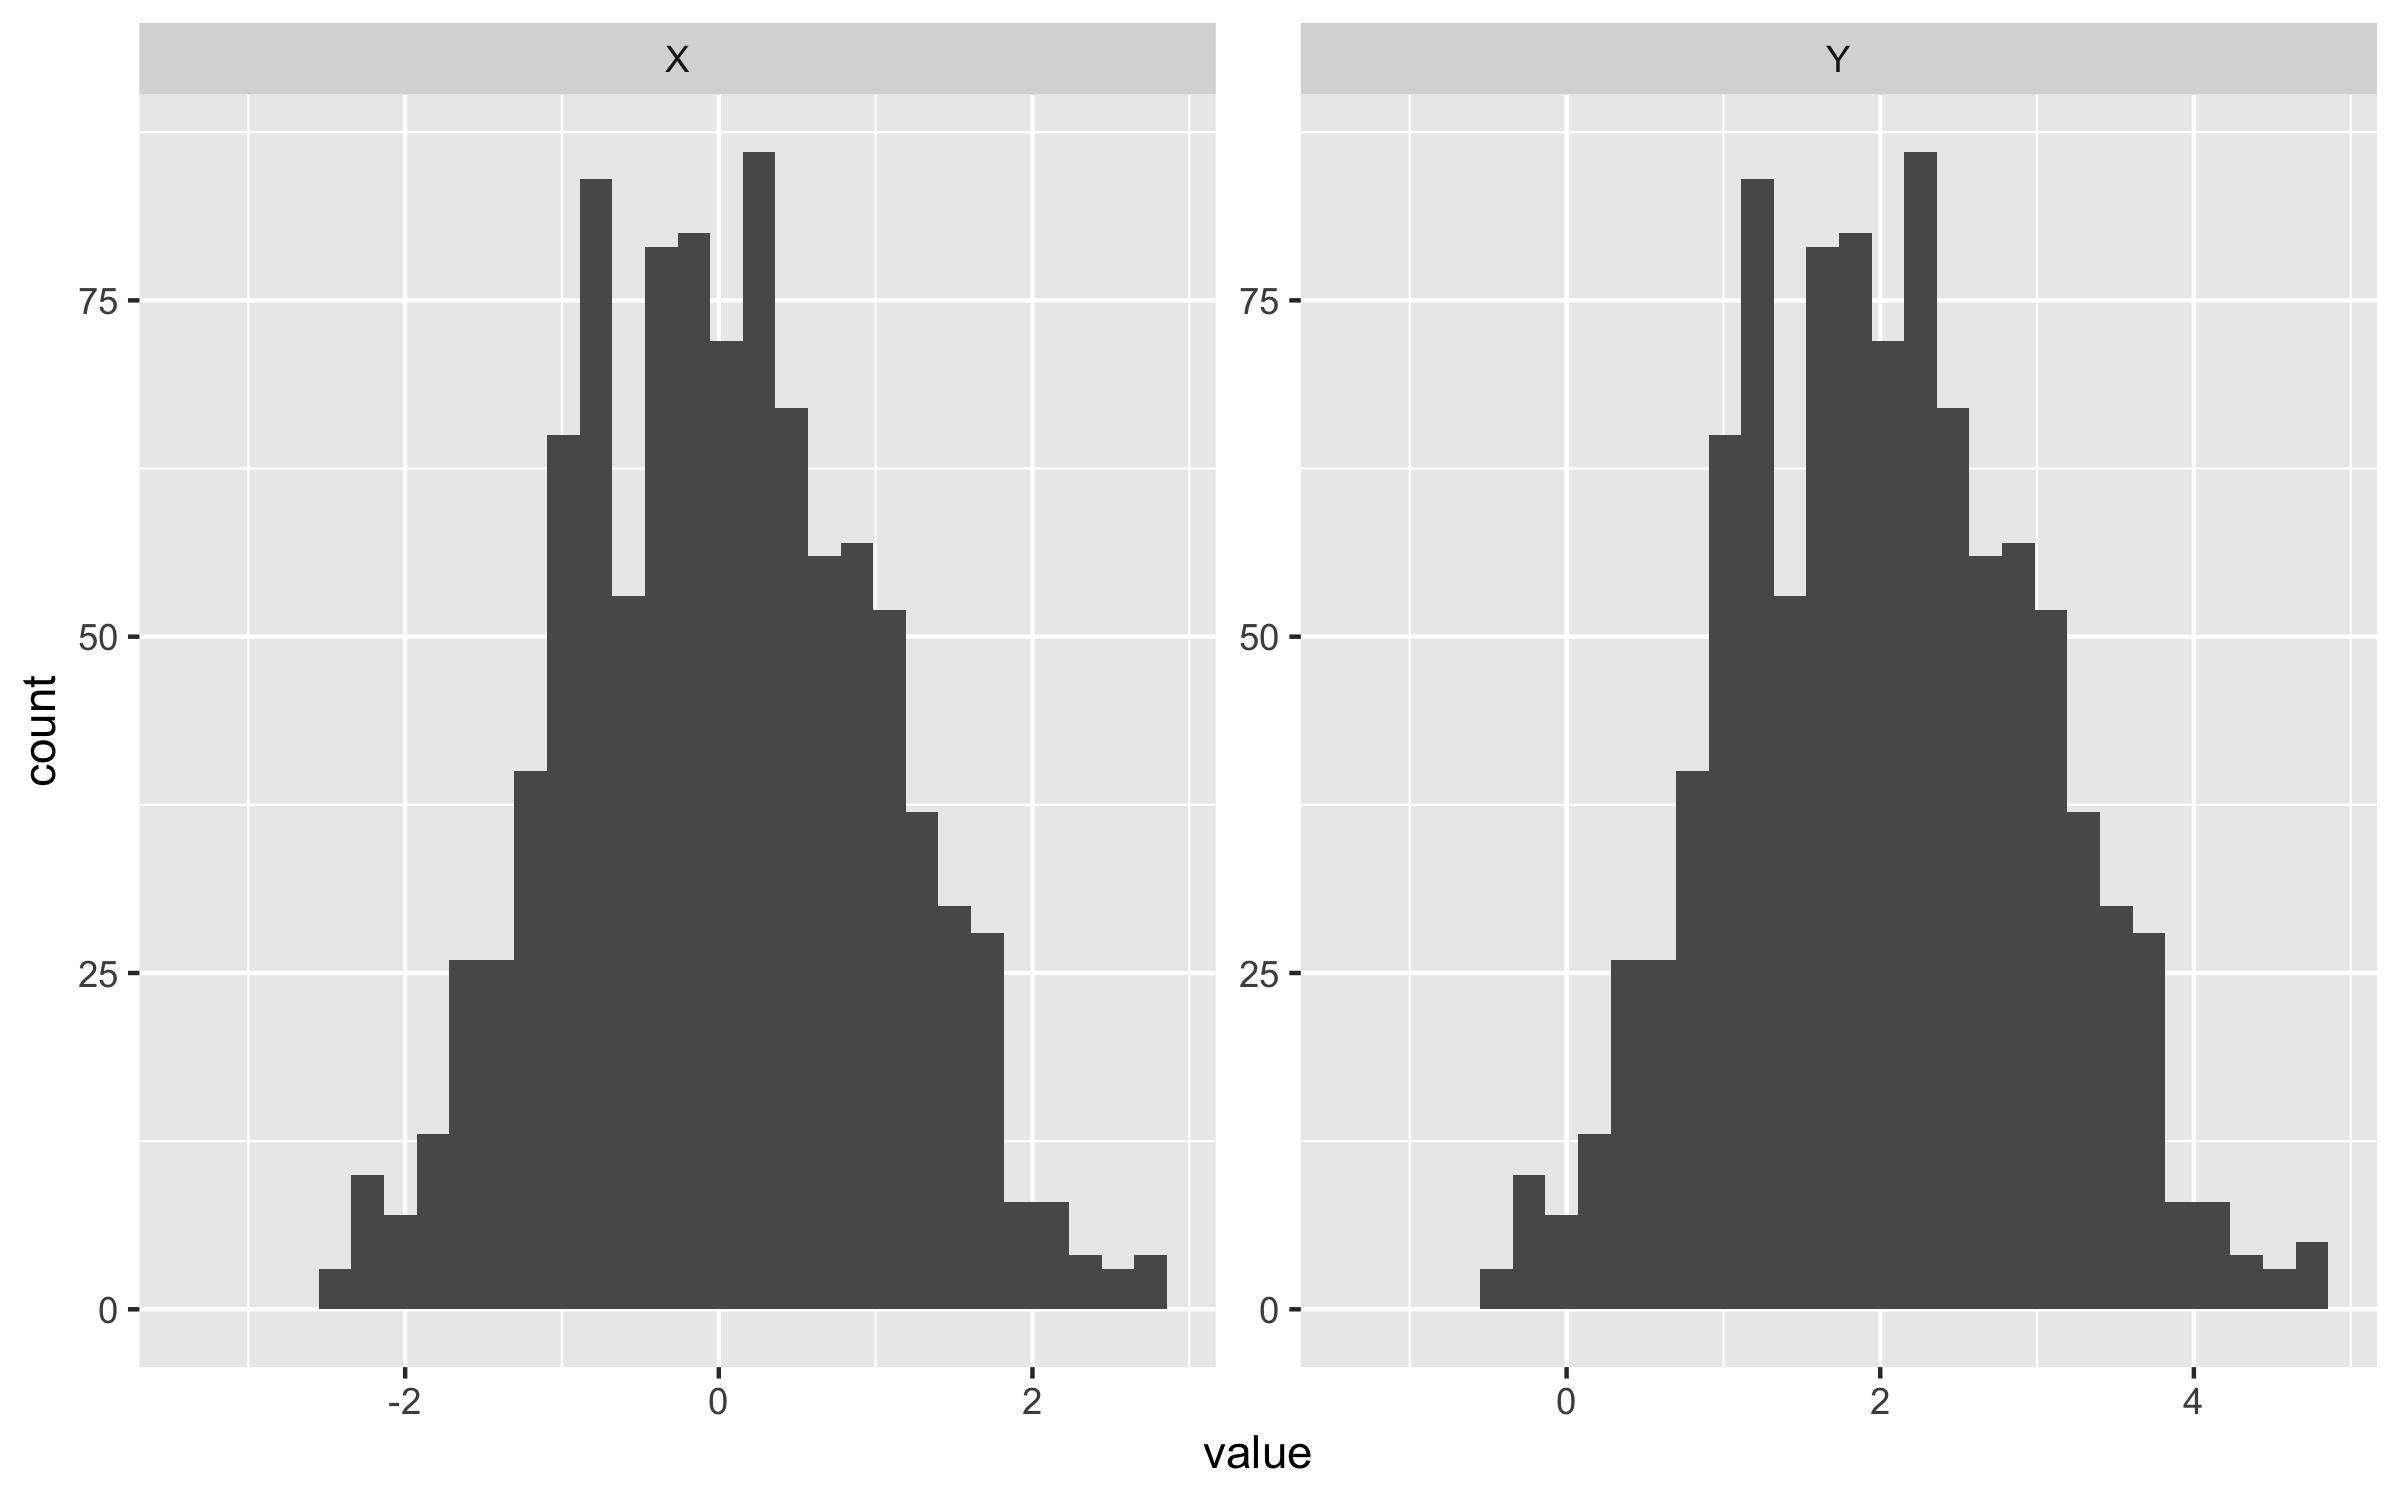

In [6]:
options(repr.plot.width = 8, repr.plot.height = 5, repr.plot.res = 300)

jags_object_1 <- jags.model(textConnection(jags_model_string_1))
mcmc_object_1 <- coda.samples(jags_object_1, variable.names = c("X","Y"), n.iter = 1000)
p <- ggs_histogram(ggs(mcmc_object_1))
p + facet_wrap(vars(Parameter), scales = "free")

Note how the histogram of the $Y$ samples looks identical to the histogram of the $X$ samples apart from being shifted to the right by $2$. The function ``ggs_histogram`` is a function from the package ``ggmcmc``. It uses ``ggplot`` to plot the histograms of the samples. The ``ggplot`` function ``facet_wrap`` is used to plot the two histograms side by side.

### Probability Distributions in ``JAGS``

Within standard ``JAGS``, only certain probability distributions are implemented and their namings follow the standard namings in the base ``R`` package ``stats``. [Recall that](https://stat.ethz.ch/R-manual/R-devel/library/stats/html/Normal.html), in base ``R``, we have the functions ``dnorm`` (evaluates the density), ``pnorm`` (evaluates the cumulative density function), ``qnorm`` (evaluates the quantile function) and ``rnorm`` (generates random samples) of the normal distribution. Equivalent implementations exist for the [Gamma distribution](https://stat.ethz.ch/R-manual/R-devel/library/stats/html/GammaDist.html), [Exponential distribution](https://stat.ethz.ch/R-manual/R-devel/library/stats/html/Exponential.html), [Log-normal distribution](https://stat.ethz.ch/R-manual/R-devel/library/stats/html/Lognormal.html), [Binomial distribution](https://stat.ethz.ch/R-manual/R-devel/library/stats/html/Binomial.html), and many others. 

An exhaustive list of avaliable distributions implemented in ``JAGS`` from the ``bugs`` module is (refer to section 9.2 "Distributions in the bugs module" in the [JAGS user manual](https://people.stat.sc.edu/hansont/stat740/jags_user_manual.pdf) for full details and their parameterisations):

1. [Bernoulli distribution](https://en.wikipedia.org/wiki/Bernoulli_distribution), $\text{Bernoulli}(p)$: ``dbern``. Discrete distribution, takes values $0$ or $1$.
2. [Beta distribution](https://en.wikipedia.org/wiki/Beta_distribution), $\text{Beta}(\alpha,\beta)$: ``dbeta``. Univariate continuous distribution, takes values in the interval $[0,1]$.
3. [Binomial distribution](https://en.wikipedia.org/wiki/Binomial_distribution), $\text{Bin}(n,p)$: ``dbin``. Discrete distribution, takes values $0,\ldots,n$.
4. [Chi-squared distribution](https://en.wikipedia.org/wiki/Chi-squared_distribution), $\chi^2(k)$: ``dchisqr``. Univariate continuous distribution, takes values in $\mathbb{R}_{\geq 0} = [0, \infty)$.
5. [Dirichlet distribution](https://en.wikipedia.org/wiki/Dirichlet_distribution), $\text{Dirichlet}(\alpha_1,\ldots,\alpha_k)$: ``ddirch``. Multivariate continuous distribution, takes values in the standard $k-1$ simplex (the set of numbers $x = (x_1,\ldots,x_k) \in \mathbb{R}^k$ such that $\sum_{i=1}^k x_i = 1$ and each $x_i \geq 0$).
6. [Double Exponential distribution](https://en.wikipedia.org/wiki/Laplace_distribution), $\text{Laplace}(\mu, b)$: ``ddexp``. Univariate continuous distribution, takes values in $\mathbb{R}$.
7. [Exponential distribution](https://en.wikipedia.org/wiki/Exponential_distribution), $\text{Exp}(\lambda)$: ``dexp``. Univariate continuous distribution, takes values in $\mathbb{R}_{\geq 0}$.
8. [F distribution](https://en.wikipedia.org/wiki/F-distribution), $\text{F}(d_1,d_2)$: ``df``. Univariate continuous distribution, takes values in $\mathbb{R}_{\geq 0}$.
9. [Gamma distribution](https://en.wikipedia.org/wiki/Gamma_distribution), $\text{Gamma}(\alpha, \beta)$: ``dgamma``. Univariate continuous distribution, takes values in $\mathbb{R}_{\geq 0}$.
10. [Generalised Gamma distribution](https://en.wikipedia.org/wiki/Generalized_gamma_distribution), $\text{GeneralisedGamma}(r, \lambda, b)$: ``dgen.gamma``. Univariate continuous distribution, takes values in $\mathbb{R}_{\geq 0}$.
11. [Hypergeometric](https://en.wikipedia.org/wiki/Hypergeometric_distribution), $\text{HyperGeometric}(n_1,n_2,m,\psi)$: ``dhyper``. Discrete distribution, takes integer values $y$ in $\max(0, n_1 + n_2 − m) \leq y \leq \min(n_1,m).$
12. [Logistic distribution](https://en.wikipedia.org/wiki/Logistic_distribution), $\text{Logistic}(\mu, s)$: ``dlogis``. Univariate continuous distribution, takes values in $\mathbb{R}$.
13. [Log-normal distribution](https://en.wikipedia.org/wiki/Log-normal_distribution), $\text{LogNormal}(\mu, \sigma^2)$: ``dlnorm``. Univariate continuous distribution, takes values in $\mathbb{R}$. In ``JAGS``, it is parameterised by the precision $\tau = 1/\sigma^{2}$ instead.
14. [Multinomial distribution](https://en.wikipedia.org/wiki/Multinomial_distribution), $\text{Multinomial}(n,p_1,\ldots,p_k)$: ``dmulti``. "Multivariate" discrete distribution, takes values $y = (y_1,\ldots,y_k)$ satisfying $\sum_{i=1}^n y_i = n$ and each $y_i \in \{0,\ldots,n\}$.
15. [Multivariate Normal distribution](https://en.wikipedia.org/wiki/Multivariate_normal_distribution), $\text{MultivariateNormal}(\underline{\mu}, \Sigma)$: ``dmnorm`` and ``dmnorm.vcov``. Multivariate continuous distribution, takes values in $\mathbb{R}^d$, where $d$ is the dimension of mean vector $\underline{\mu}$. The ``JAGS`` distribution ``dmnorm.cov`` is parameterised by a covariance matrix $\Sigma$, whereas ``dmnorm`` is parameterised by a precision matrix $\Sigma^{-1}$.
16. [Multivarite Student-t distribution](https://en.wikipedia.org/wiki/Multivariate_t-distribution), $\text{Multivariate-t}(\underline{\mu}, \Sigma, \eta)$: ``dmt``. Multivariate continuous distribution, takes values in $\mathbb{R}^d$, where $d$ is the dimension of the location vector $\underline{\mu}$.
17. [Negative Binomial distribution](https://en.wikipedia.org/wiki/Negative_binomial_distribution), $\text{NegBin}(p, r)$: ``dnegbin``. Discrete distribution, takes values in $\mathbb{N} = \{0,1,2,3,\ldots\}$.
18. [Noncentral Chi-squared distribution](https://en.wikipedia.org/wiki/Noncentral_chi-squared_distribution), $\text{NonCentralChiSquare}(k, \delta)$: ``dnchisqr``. Univariate continuous distribution, takes values in $\mathbb{R}_{\geq 0}$.
19. [Noncentral Student-t](https://en.wikipedia.org/wiki/Noncentral_t-distribution), $\text{NonCentral-t}(\mu, \tau, d)$: ``dnt``. Univariate continuous distribution, takes values in $\mathbb{R}$.
20. [Normal distribution](https://en.wikipedia.org/wiki/Normal_distribution), $\mathcal{N}(\mu,\sigma^2)$: ``dnorm``. Univariate continuous distribution, takes values in $\mathbb{R}$. In ``JAGS``, it is parameterised by the precision $\tau = 1/\sigma^{2}$ instead.
21. [Pareto distribution](https://en.wikipedia.org/wiki/Pareto_distribution), $\text{Pareto}(\alpha,c)$: ``dpar``. Univariate continuous distribution, takes values in $[c, \infty)$.
22. [Poisson distribution](https://en.wikipedia.org/wiki/Poisson_distribution), $\text{Poisson}(\lambda)$: ``dpois``. Discrete distribution taking values in $\mathbb{N} = \{0,1,2,3,\ldots\}$.
23. Sampling with replacement: ``dsample``.
24. [Student-t distribution](https://en.wikipedia.org/wiki/Student%27s_t-distribution), $\text{Student-t}(\mu,\tau,d)$: ``dt``. Univariate continuous distribution taking values in $\mathbb{R}$. Equivalent to non-central Student-t (typically the Student-t distribution is parameterised by just the degrees of freedom $d$, the introduction of location and precision parameters $\mu$ and $\tau$ turn it into a non-central distribution). A [heavier tailed](https://en.wikipedia.org/wiki/Heavy-tailed_distribution) Normal distribution.
25. [Uniform distribution](https://en.wikipedia.org/wiki/Continuous_uniform_distribution), $\text{Unif}(a,b)$: ``dunif``. Univariate continuous distribution, taking values in $[a,b]$.
26. [Weibull distribution](https://en.wikipedia.org/wiki/Weibull_distribution), $\text{Weibull}(v,\lambda)$: ``dweib``. Univariate continuous distribution, taking values in $\mathbb{R}_{\geq 0}$.
27. [Wishart distribution](https://en.wikipedia.org/wiki/Wishart_distribution), $\text{Wishart}(R, d)$: ``dwish``. Multivariate continuous distribution, taking values in the space of [symmetric](https://en.wikipedia.org/wiki/Symmetric_matrix), [positive definite](https://en.wikipedia.org/wiki/Definite_matrix) matrices.

It is possible to [extend](https://escholarship.org/content/qt1hn8q7d7/qt1hn8q7d7_noSplash_d0f8b25036a059562eda4bde9d12dce1.pdf) ``JAGS`` to implement other distributions by writing your own ``JAGS`` module (the ``bugs`` module comes with ``JAGS``). However, it may be quicker to implement your own sampler in ``R`` (similar to what we did in the previous problem). 

#### Sampling from Independent Distributions

Let's run another ``JAGS`` program with a bunch of different independent distributions (feel free to alter the parameters and use different distributions):

In [7]:
jags_model_string_2 <- "
    model{
        beta ~ dbeta(5, 2) # beta distribution
        chi_square ~ dchisqr(5) # chi square distribution
        log_normal ~ dlnorm(2, 5) # log normal distribution
        student_t ~ dt(0, 30, 5) # student-t distribution
        weibull ~ dweib(5, 1) # weibull distribution
        logistic ~ dlogis(30, 10) # logistic distribution
    }
    "

Let's run this program:

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 0
   Unobserved stochastic nodes: 6
   Total graph size: 12

Initializing model



Warning message in FUN(X[[i]], ...):
“Failed to set trace monitor for student_t2
Variable student_t2 not found
”


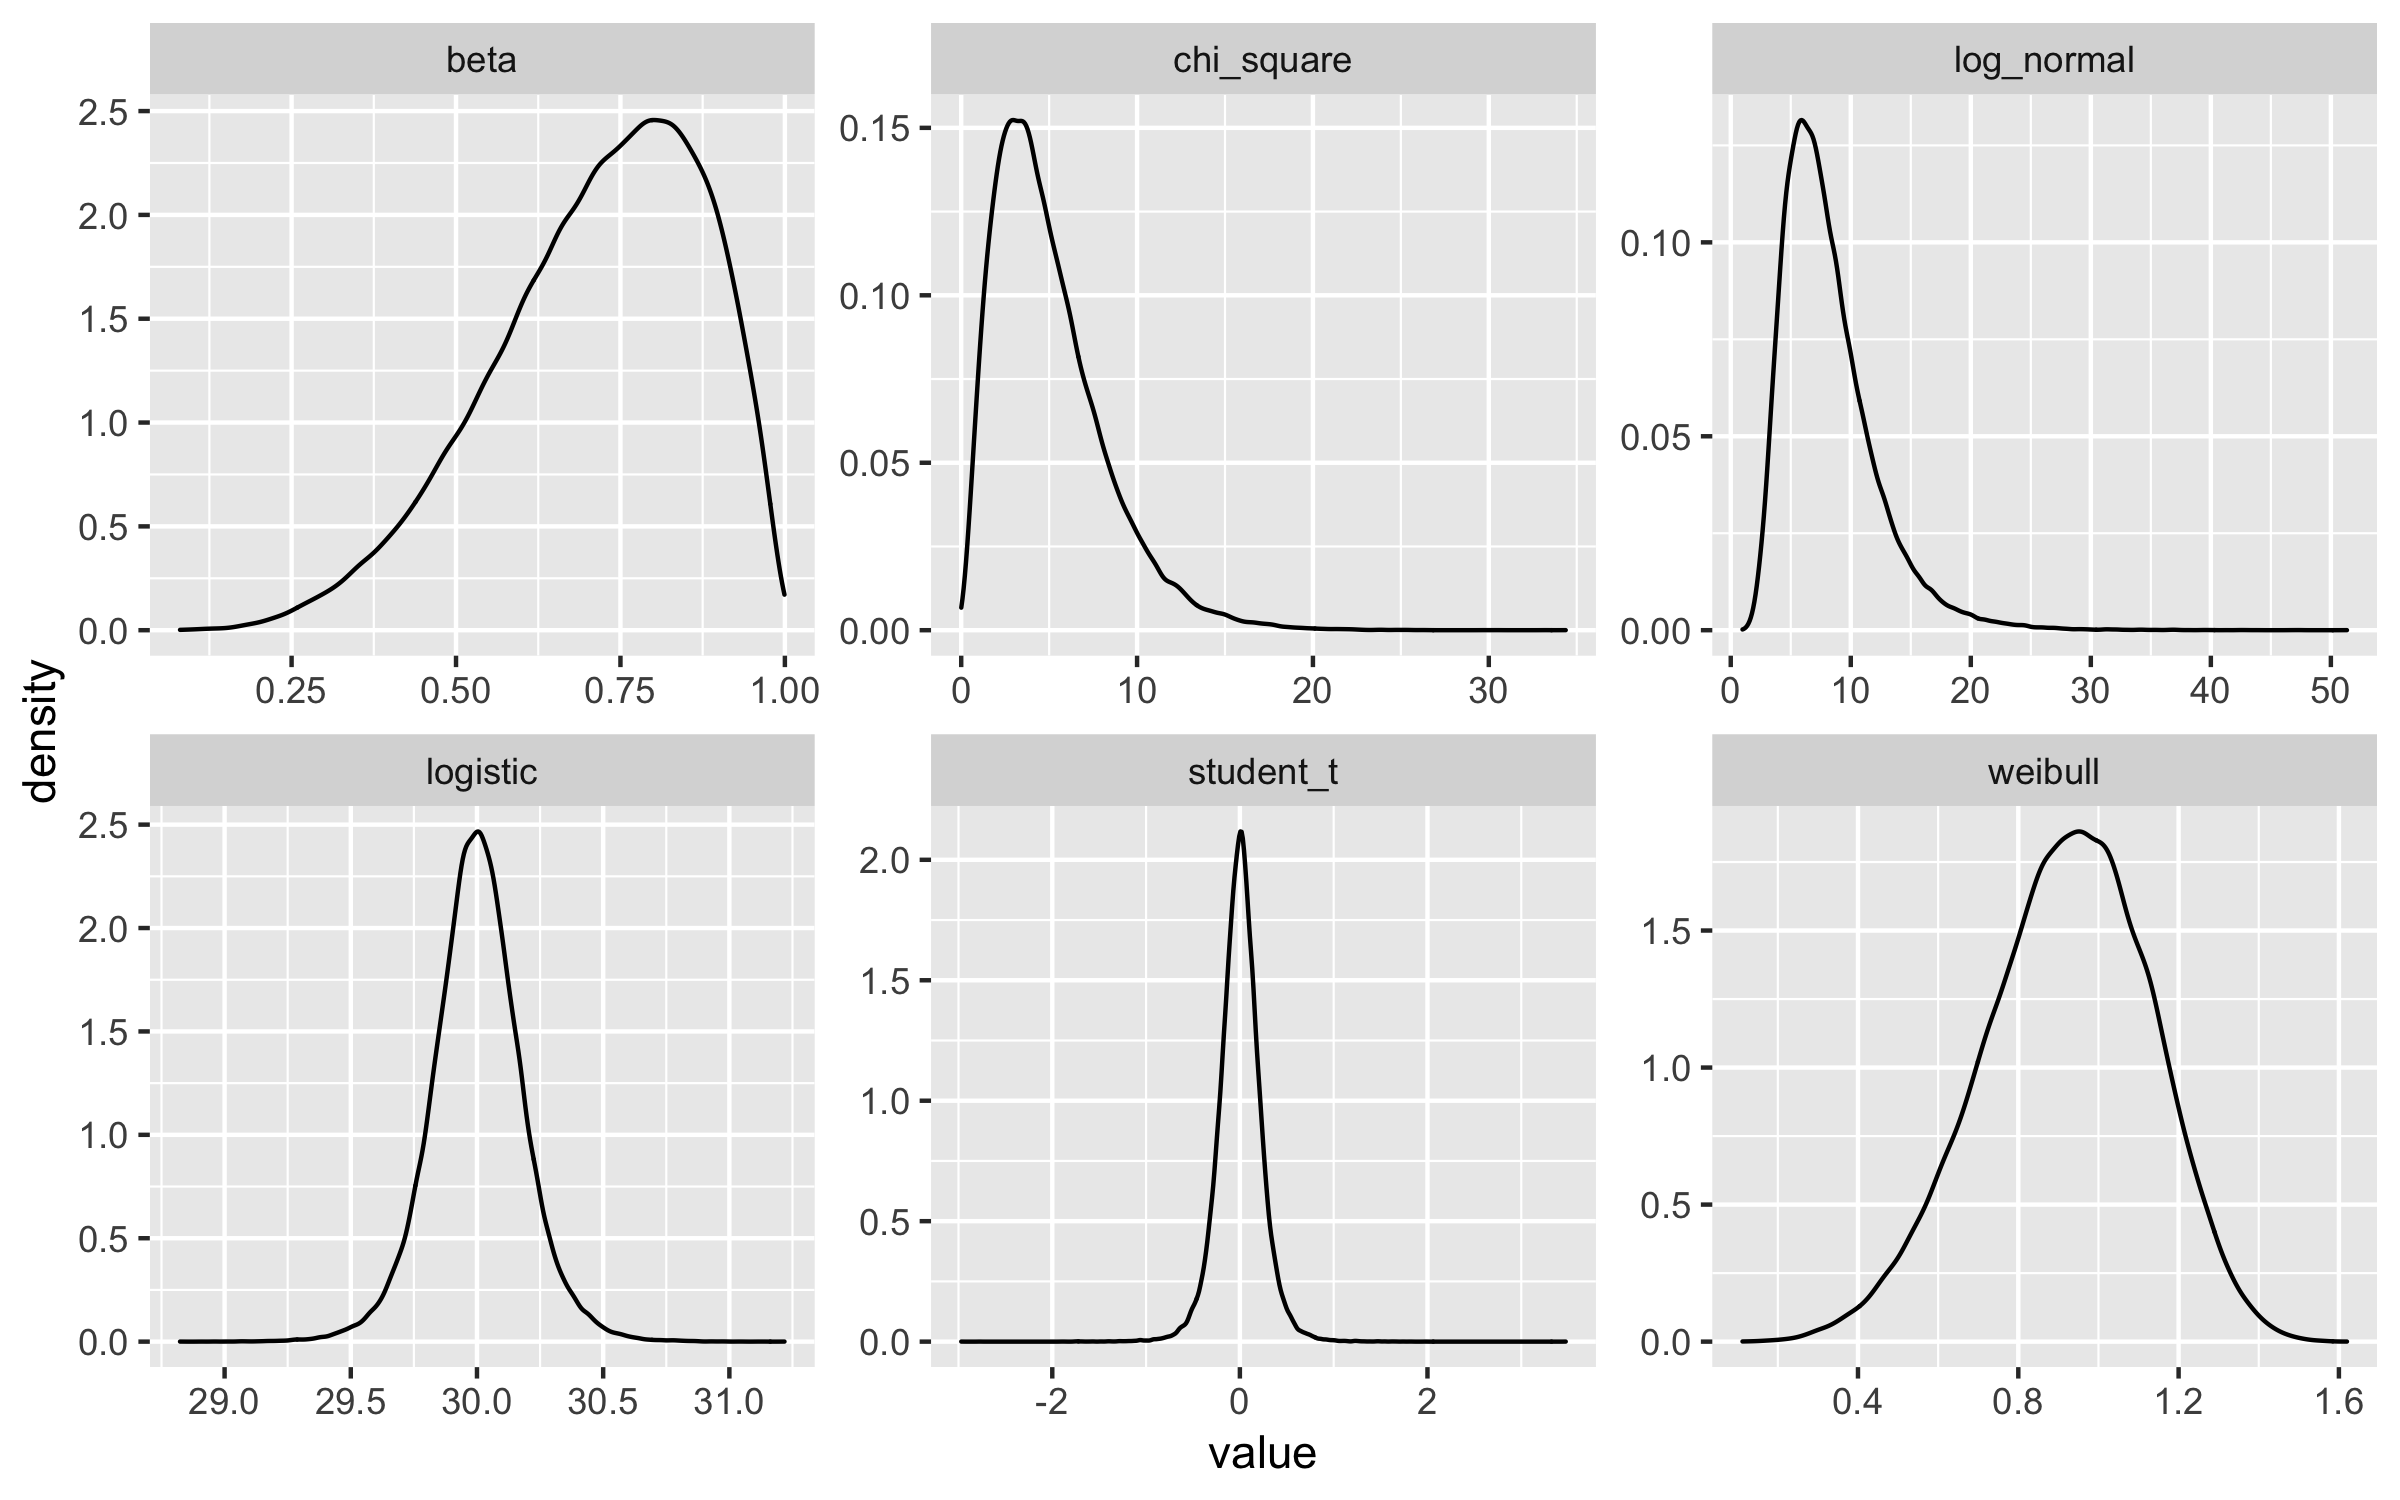

In [8]:
options(repr.plot.width = 8, repr.plot.height = 5, repr.plot.res = 300)

jags_object_2 <- jags.model(textConnection(jags_model_string_2))
mcmc_object_2 <- coda.samples(jags_object_2, variable.names = c("beta", "chi_square", "log_normal", "student_t","student_t2", "weibull", "logistic"), n.iter = 100000)
p <- ggs_density(ggs(mcmc_object_2))
p + facet_wrap(vars(Parameter), scales = "free")

In the above, we have sampled $100,000$ samples from each of the variables specified in the ``JAGS`` program ``jags_model_string_2``. The function ``ggs_density`` is from ``ggmcmc`` and uses ``ggplot`` to plot an empirical density from the samples (see [``geom_density``](https://ggplot2.tidyverse.org/reference/geom_density.html)). 

By "empirical density", I mean a smooth estimation of the density function that is computed only using the outputted MCMC samples. The particular estimation methodology used is [kernel density estimation](https://en.wikipedia.org/wiki/Kernel_density_estimation).

#### Sampling from Dependent Variables

So far, we have only sampled from independent variables. In order to perform Bayesian inference we need to introduce some dependencies. 

Have a guess at what the following program is doing:

In [9]:
jags_model_string_3 <- "
    model{
        eta <- 0
        lambda <- 1
        alpha <- 20
        beta <- 5

        inv_sigma ~ dgamma(alpha, beta) # gamma distribution
        sigma <- 1 / inv_sigma # inverse-gamma samples

        mu ~ dnorm(eta, lambda / sigma) # dnorm is parameterised by the precision (1/variance)
    }
    "

Let's run it:

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 0
   Unobserved stochastic nodes: 2
   Total graph size: 8

Initializing model



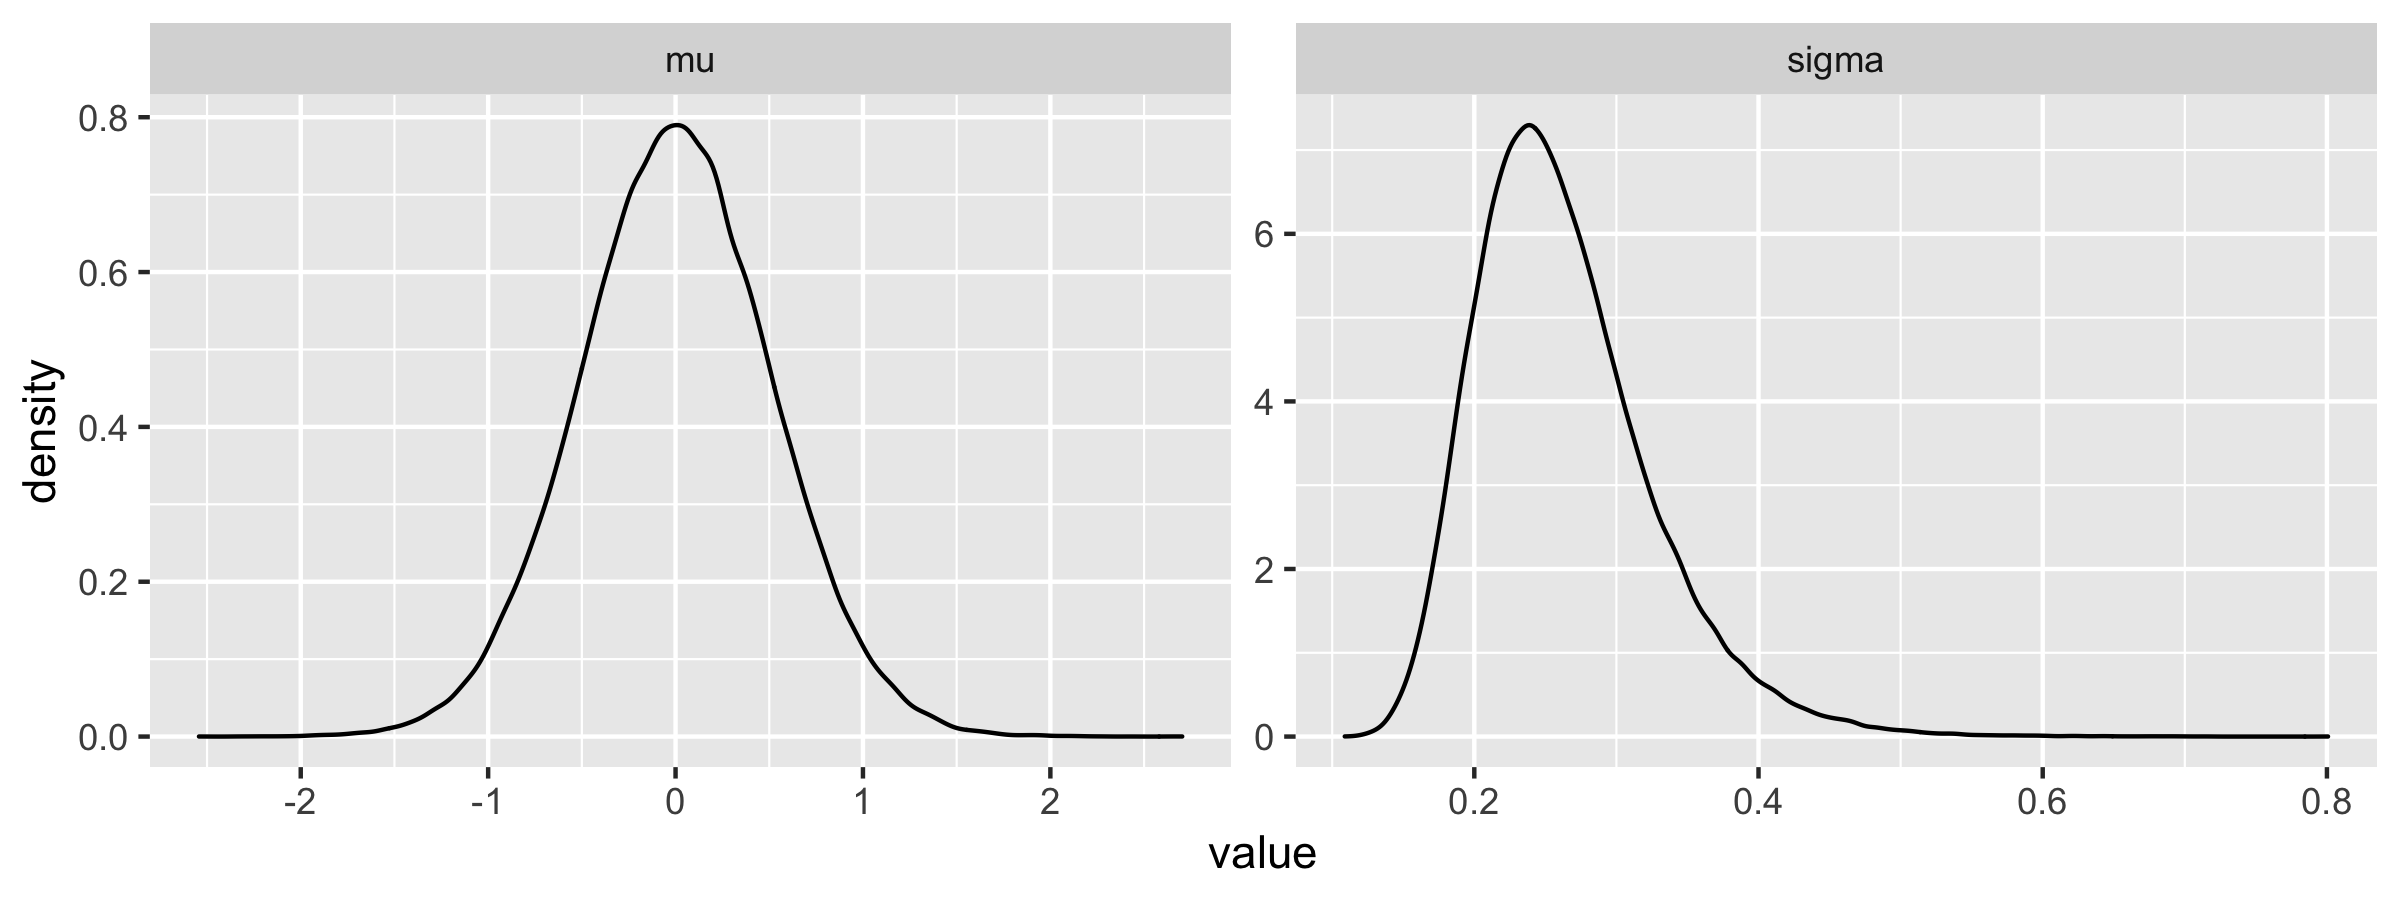

In [11]:
options(repr.plot.width = 8, repr.plot.height = 3, repr.plot.res = 300)

jags_object_3 <- jags.model(textConnection(jags_model_string_3))
mcmc_object_3 <- coda.samples(jags_object_3, variable.names = c("mu", "sigma"), n.iter = 100000)
p <- ggs_density(ggs(mcmc_object_3))
p + facet_wrap(vars(Parameter), scales = "free")

We have asked ``JAGS`` to output samples from both ``mu`` and ``sigma``. In the above plot, we are plotting estimates of the marginal densities.

Have a look at the joint density of these samples and compare with a Normal-Inverse Gamma density plot:

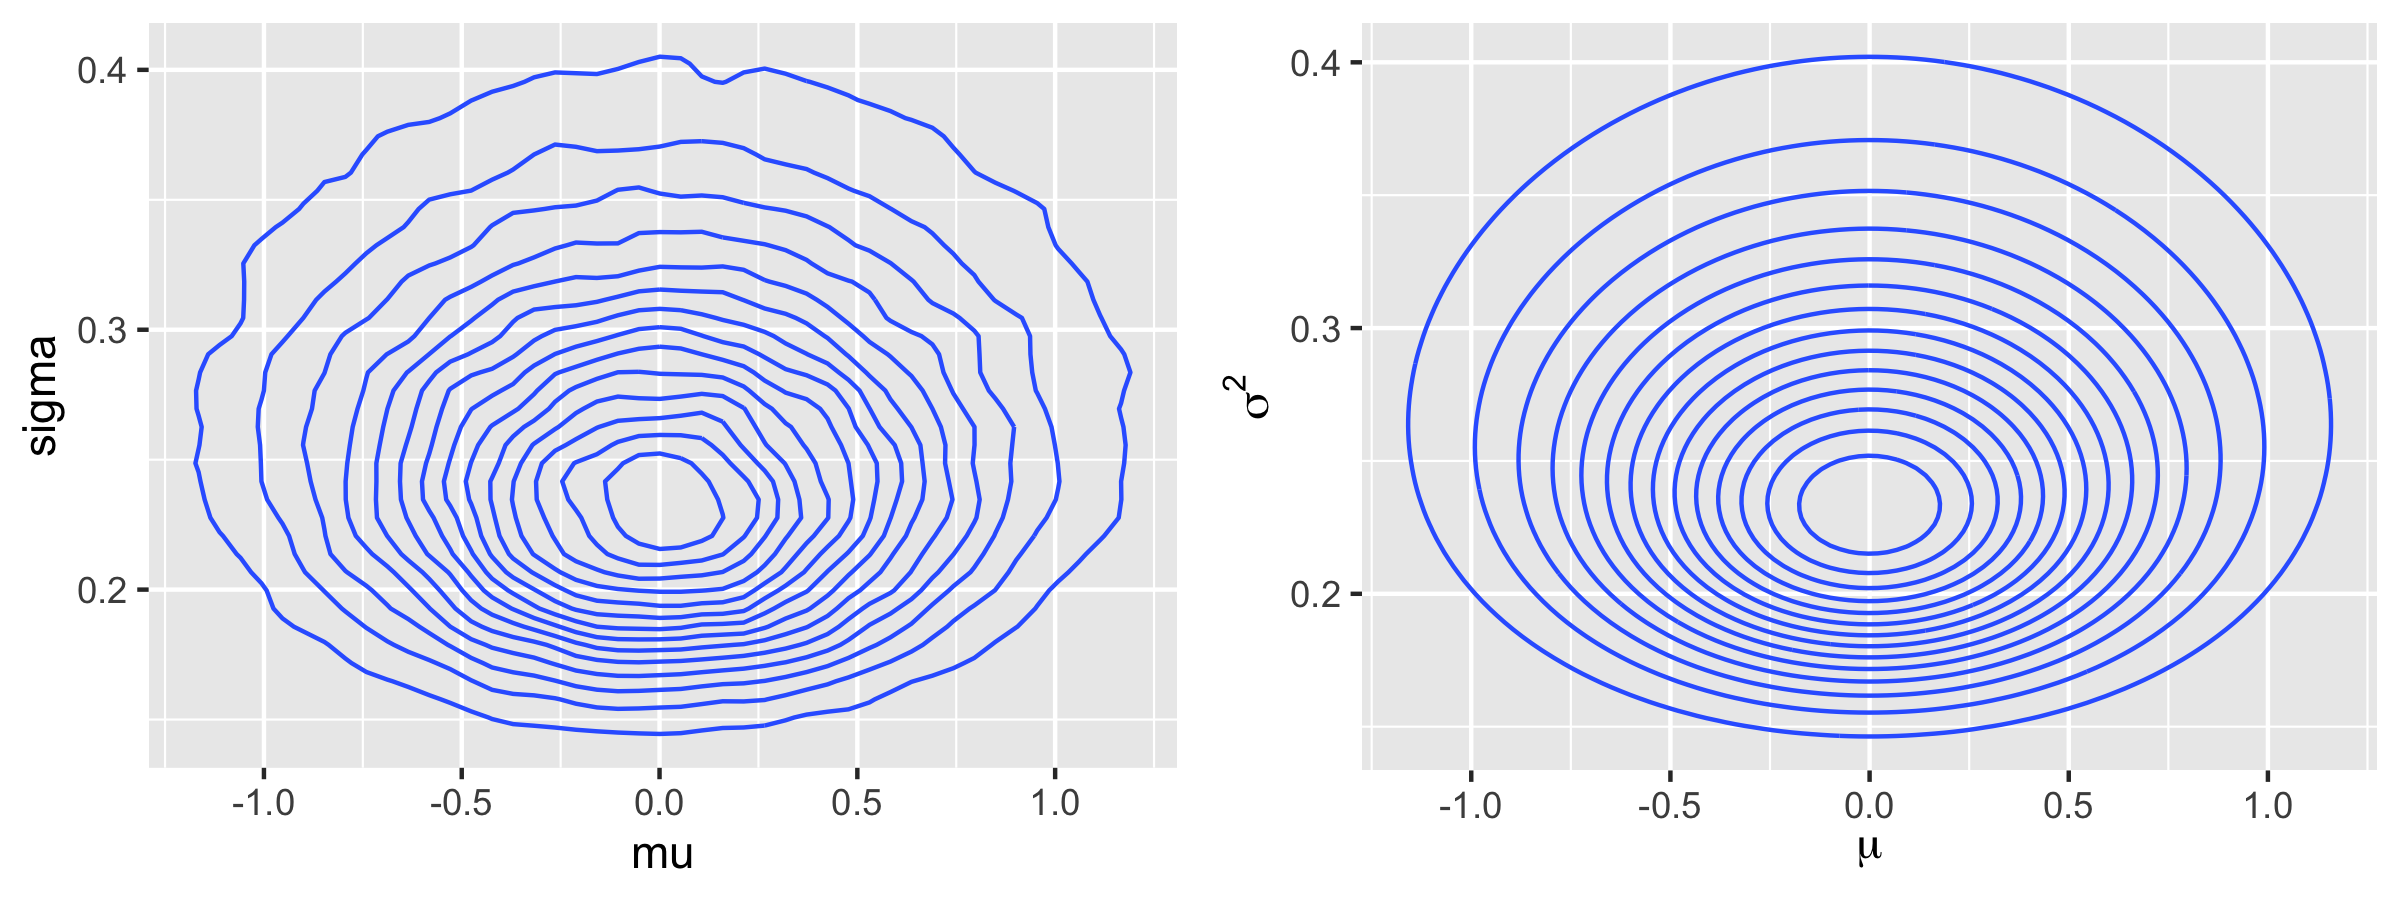

In [12]:
# The following is plotting the joint estimated density using the MCMC output:

ggplot_data <- data.frame(as.matrix(mcmc_object_3))

mcmc_density_plot <- ggplot(ggplot_data, aes(x = mu, y = sigma)) +
    stat_density_2d(bins = 15)


# The following plots the Normal-inverse Gamma density function
# with the same parameter values used in the JAGS model:

dnorminvgamma <- function(mu, sigma, parameters, log = FALSE) {
    eta <- parameters$eta # assign each parameter from the vector
    lambda <- parameters$lambda
    alpha <- parameters$alpha
    beta <- parameters$beta

    constant <- 0.5 * log(lambda) - 0.5 * log(2 * pi) + alpha * log(beta) - lgamma(alpha)
    sigma_term <- - 0.5 * log(sigma) - (alpha + 1) * log(sigma)
    exp_term <- - (2 * beta + lambda * (eta - mu) ** 2) / (2 * sigma)

    output <- constant + sigma_term + exp_term
    if (log == TRUE) {
      return(output)
    }
    else {
      return(exp(output))
    }
}

params <- list(eta = 0, lambda = 1, alpha = 20, beta = 5)
density <- function(mu, sigma) dnorminvgamma(mu, sigma, params)
 
# We extract the range of the MCMC plot so we can
# automatically pick appropriate ranges to plot the Normal-Inverse
# Gamma density:
mcmc_plot_build <- ggplot_build(mcmc_density_plot)
x_range <- mcmc_plot_build$layout$panel_scales_x[[1]]$range$range
y_range <- mcmc_plot_build$layout$panel_scales_y[[1]]$range$range

mu_mesh <- seq(x_range[1], x_range[2], length.out = 100)
sigma_mesh <- seq(y_range[1], y_range[2], length.out = 100)

z <- outer(mu_mesh, sigma_mesh, density)
z <- replace(z, is.na(z), 0)

rownames(z) <- mu_mesh
colnames(z) <- sigma_mesh

norminvgamma_plot <- as.data.frame(z) %>% # these %>% are "pipes" from the package magrittr
  rownames_to_column(var = "row") %>% # they allow you to compose functions
  gather(col, value, -row) %>%
  mutate(row = as.numeric(row),
         col = as.numeric(col)) %>%
  ggplot(aes(row, col, z = value)) +
    geom_contour(bins = 15, show.legend = FALSE) +
    xlab(expression(mu)) + ylab(expression(sigma^2))

# The following plot_grid is from the package cowplot
# It allows us to easily plot these two plots side-by-side

plot_grid(mcmc_density_plot, norminvgamma_plot)

Let's break the ``JAGS`` program down:

    "
    model{
        eta <- 0
        lambda <- 1
        alpha <- 20
        beta <- 5

        inv_sigma ~ dgamma(alpha, beta) # gamma distribution
        sigma <- 1 / inv_sigma # inverse-gamma samples

        mu ~ dnorm(eta, lambda / sigma) # dnorm is parameterised by the precision (1/variance)
    }
    "

The first four lines define our parameter values that are used in the subsequent code. Each outputted sample from our ``JAGS`` program is obtained as follows:

1. Sample once from the $\text{Gamma}(\alpha, \beta)$ distribution. Call this sample $x_i$.
2. Perform the transformation $y_i = 1/x_i$. Therefore, $y_i$ is a sample from the $\text{InverseGamma}(\alpha,\beta)$ distribution (by definition).
3. Sample once from the $\mathcal{N}(\eta, y_i / \lambda)$ distribution (in ``JAGS`` the Normal distribution is parameterised by the precision $\tau = 1/\sigma^2$). Call this sample $z_i$.

Therefore, the joint sample $(z_i, y_i)$ is a sample from the $\text{NormalInverseGamma}(\eta, \mu, \alpha, \beta)$ distribution. 

Recall from Problem 1 (refer to "Problem 1: Conjugate Inference"), that a definition of the Normal Inverse Gamma is 
$$ Y \sim \text{InverseGamma}(\alpha,\beta) $$
$$ Z | Y = y \sim \mathcal{N}(\eta, y / \lambda ), $$
then $(Z,Y) \sim \text{NormalInverseGamma}(\eta, \lambda, \alpha, \beta)$.

### Functions in ``JAGS``

Similar to how standard ``JAGS`` only supports specific probability distributions, ``JAGS`` also only supports certain functions. These functions are used to transform samples into a form that is useful for our inference problem. 

As we have already seen in our previous examples, the [infix operators](https://en.wikipedia.org/wiki/Infix_notation) ``+`` and ``/`` are supported by ``JAGS``. Refer to section 8.1 "Functions in the base module" and section 9.1 "Functions in the bugs module" in the [JAGS user manual](https://people.stat.sc.edu/hansont/stat740/jags_user_manual.pdf) for an exhaustive list. Most of the functions implemented in standard ``JAGS`` are compatible with ``R`` and most ``R`` math functions are compatible with ``JAGS``.

Again, it is possible to [implement your own](https://escholarship.org/content/qt1hn8q7d7/qt1hn8q7d7_noSplash_d0f8b25036a059562eda4bde9d12dce1.pdf) functions in ``JAGS`` by writing your own ``JAGS`` module. Please feel free to do this!

The following is a brief list of notable functions and the functions that will be used in this course:

1. All the arithmetic operators: Addition ``x + y``. Subtraction ``x - y``. Multiplication ``x * y``. Division ``x / y``. Sequence ``x : y``.
2. Trigonometric Functions: Sine ``sin(x)``. Arc-sine ``arcsin(x)``. Cosine ``cos(x)``. Arc-cosine ``arccos(x)``. Tangent ``tan(x)``. Arc-tangent ``arctan(x)``.
3. Hyperbolic Functions: Hyperbolic Sine ``sinh(x)``. Hyperbolic Arc-sine ``arcsinh(x)``. Hyperbolic Cosine ``cosh(x)``. Hyperbolic Arc-cosine ``arccosh(x)``. Hyperbolic Tangent ``tanh(x)``. Hyperbolic Arc-tangent ``arctanh(x)``.
4. Absolute Value, ``abs(x)``: $|x|$
5. Natural Logarithm, ``log(x)``: $\log(x)$
6. Exponential, ``exp(x)``: $\exp(x)$
7. Inner Product, ``inprod(x, y)``: $x\cdot y = x^\top y = x_1y_1 + \ldots + x_ny_n$, where $x = (x_1,\ldots,x_n)$ and $y = (y_1,\ldots,y_n)$. 
8. Power function, ``pow(x,y)``: $x^y$.

These functions are used in the standard way within a ``JAGS`` program:

In [14]:
jags_model_string_4 <- "
    model{
        X ~ dnorm(0, 2)
        Y ~ dlnorm(0, 2)
        sinX ~ dnorm(sin(5 * X), 100)
        expX ~ dnorm(exp(X), 1000)
        logY ~ dnorm(log(Y), 1000)
    }
    "

Let's run this ``JAGS`` program and plot some of the joint distributions:

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 0
   Unobserved stochastic nodes: 5
   Total graph size: 14

Initializing model



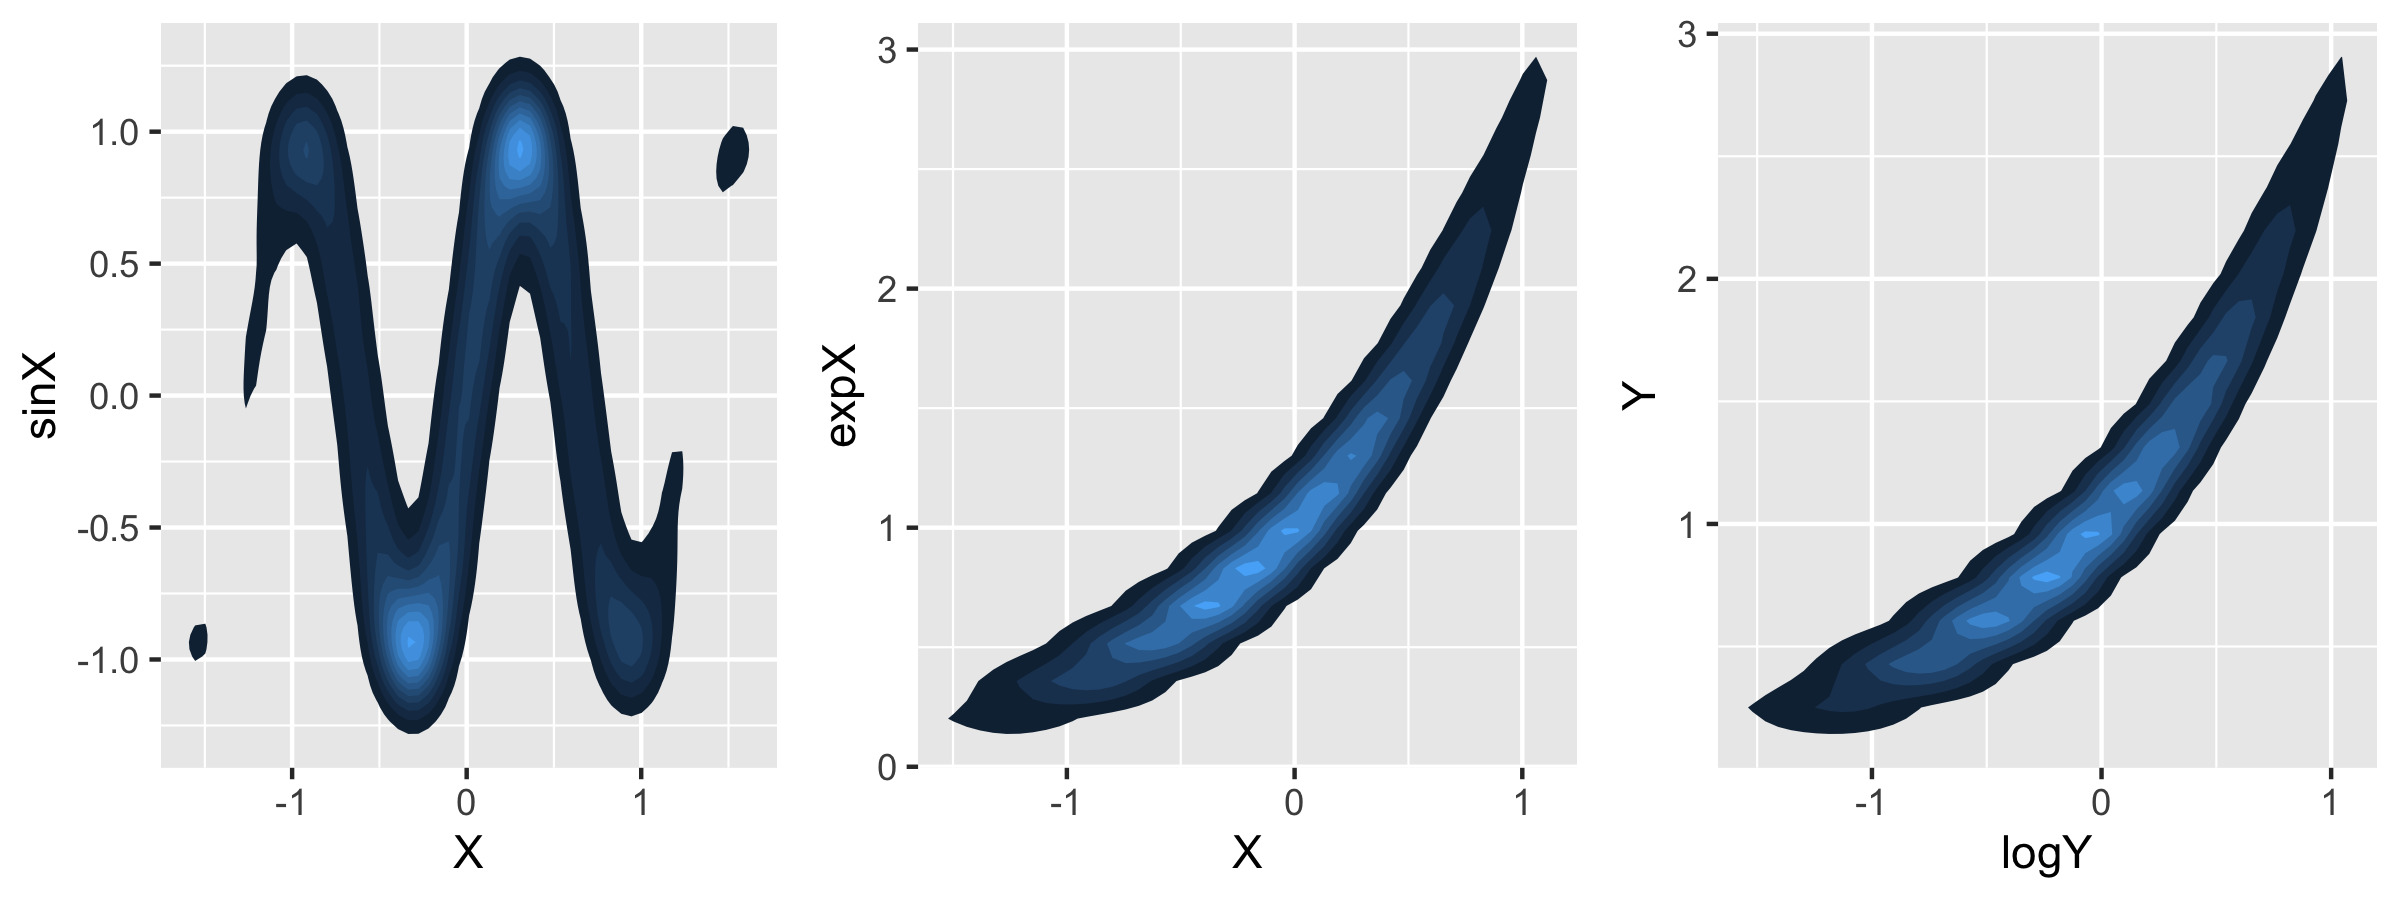

In [15]:
options(repr.plot.width = 8, repr.plot.height = 3, repr.plot.res = 300)

jags_object_4 <- jags.model(textConnection(jags_model_string_4))
mcmc_object_4 <- coda.samples(jags_object_4, variable.names = c("X", "Y", "sinX", "expX", "logY"), n.iter = 20000)

ggplot_data <- data.frame(as.matrix(mcmc_object_4))

density_X_sinX <- ggplot(ggplot_data, aes(x = X, y = sinX)) +
    stat_density_2d(aes(fill = ..level..), geom = "polygon") + theme(legend.position = "none")

density_X_expX <- ggplot(ggplot_data, aes(x = X, y = expX)) +
   stat_density_2d(aes(fill = ..level..), geom = "polygon") + theme(legend.position = "none")

density_Y_logY <- ggplot(ggplot_data, aes(x = logY, y = Y)) +
    stat_density_2d(aes(fill = ..level..), geom = "polygon") + theme(legend.position = "none")

plot_grid(density_X_sinX, density_X_expX, density_Y_logY, nrow = 1)


Try to explain the behaviour in the above plot. In particular try to explain why the two rightmost plots look similar. (Hint: If $X \sim \mathcal{N}(\mu, \sigma^2)$ then $Y = \exp(X) \sim \text{LogNormal}(\mu,\sigma^2)$).

### Arrays in ``JAGS``

Arrays in ``JAGS`` can be vectors (one-dimensional), or matrices (two-dimensional), or they may have more than two dimensions.

Elements of an array can be accessed in the usual way:

        vector <- c(1, 2, 3, 4)
        element_of_vector <- vector[2]

You are also able to use the combine function ``c`` in order to construct vectors.

Similarly, for a two-dimensional array ``A``, the element in row ``r`` and column ``c`` is accessed as ``A[r,c]``.

More complicated subsets of a matrix ``A`` can be obtained by expressions of the form ``A[rows, cols]``, where ``rows`` is an integer vector of row indices and ``cols`` is an integer vector of column indicies.

For example, if ``A`` is a $n\times m$ matrix, the expression ``A[c(1,2), 1:m]`` is the first two rows of ``A``.

You are also able to omit an index expression in any dimension, and this implies taking the whole range of
possible indices. For example, the expression ``A[1,]`` is equivalent to ``A[1,1:m]`` and ``A[,2]`` is equivalent to ``A[1:n, 2]``.

Therefore, the expression ``A[r,]`` is the ``r``th row of the matrix ``A`` and ``A[,c]`` is the ``c``th column of ``A``.

Arrays in ``JAGS`` are usually either supplied as data or constructed using for-loops, which we discuss next:


### For-loops in ``JAGS``

For loops are used in the the BUGS language to simplify writing repeated expressions. A for
loop takes the form:

    for (i in exp) {
    }

where ``exp`` is any expression that evaluates to an integer vector. Usually, this will be of the form

    for (i in 1:N) {
    }

The code within inside the curly braces of the for-loop will then be expanded with the index ``i`` taking each value in the vector
``exp``.

For example, the code

    for (i in 1:3) {
        Y[i] ~ dnorm(0, 1)
    }

is equivalent to 

    for (i in c(1, 2, 3)) {
        Y[i] ~ dnorm(0, 1)
    }

and equivalent to

    Y[1] ~ dnorm(0, 1)
    Y[2] ~ dnorm(0, 1)
    Y[3] ~ dnorm(0, 1)

You are able to nest for-loops too, this is how higher-dimensional arrays are constructed in ``JAGS``. For example, consider the following snippet:

    for (i in 1:2) {
        for (j in 1:2) {
            Y[i, j] ~ dnorm(0,1)
            matrix[i, j] <- i + j
         }
    }

This creates a random matrix ``Y``, with each element ``Y[i, j]`` being a distinct random variable distribute according to ``dnorm(0, 1)`` and a matrix ``matrix``, taking the values ``matrix[1, 1] = 2``, ``matrix[1, 2] = 3``, ``matrix[2, 1] = 3`` and ``matrix[2, 2] = 4``.

## What is ``rjags`` and ``coda``?

### ``rjags``

The ``R`` package [``rjags``](https://cran.r-project.org/web/packages/rjags/index.html) ([link](https://www.rdocumentation.org/packages/rjags/versions/4-12) to documentation) provides an interface with ``JAGS``. The functions from this package that we will use are:
- [``jags.model``](https://www.rdocumentation.org/packages/rjags/versions/4-12/topics/jags.model): The function which turns our ``JAGS`` program and data into a ``JAGS`` model object. This is the function used as our entry point to ``JAGS``.
- [``update``](https://www.rdocumentation.org/packages/rjags/versions/4-12/topics/update): Runs the Gibbs sampler for a given number of iterations. There are also optional arguments for graphical features displaying the progress of the sampler. This is typically used to "burn-in".
- [``coda.samples``](https://www.rdocumentation.org/packages/rjags/versions/4-12/topics/coda.samples): Runs the Gibbs sampler for a given number of iterations and also outputs the samples of our variable of interest into a convenient format, an ``mcmc`` object. The output format can be plotted and investigated using ``coda`` and ``ggmcmc``.

The typical use case is the following:

    jags_object <- jags.model(jags_program, data)
    update(jags_object, n.iter = 1000, progress.bar = "text") # burn in
    mcmc_object <- coda.samples(jags_object, variable.names, n.iter = 10000, thin = 1)

Line-by-line, the above code achieves the following:
1. Instantiates a ``JAGS`` model object. To do this, we provide a ``JAGS`` program (``jags_program``) and the data we will be conditioning on (``data``) to the ``rjags`` function ``jags.model``. The data must take the form of an ``R`` list or dataframe, where the attribute names correspond to the variables in the ``JAGS`` program. The output ``jags_object`` is the ``JAGS`` representation of the Gibbs sampler. 
2. Runs the Gibbs sampler ``jags_object`` for $1000$ iterations. 
3. Runs the Gibbs sampler ``jags_object`` until $10,000$ samples are obtained. Since we used a thinning parameter of ``thin = 1``, this just runs the Gibbs sampler for $10,000$ iterations. If we instead used ``thin = 2``, we would take every second sample from the Gibbs sampler and so to obtain $10,000$ samples, the Gibbs sampler would run for $20,000$ iterations. The input ``variable.names`` is a vector of variable names that correspond to variable names in the ``JAGS`` program. The $10,000$ posterior samples corresponding to ``variable.names`` are then outputted.

### ``coda``

The ``R`` package [``coda``](https://cran.r-project.org/web/packages/coda/index.html) ([link](https://www.rdocumentation.org/packages/coda/versions/0.19-4) to documentation) provides functions for summarising output from ``JAGS``. In these notebooks, we will also use the ``R`` package [``ggmcmc``](https://cran.rstudio.com/web/packages/ggmcmc/index.html) ([link](https://www.rdocumentation.org/packages/ggmcmc/versions/1.5.1.1) to documentation) for plotting MCMC output. This package uses ``ggplot`` to summarise the MCMC output and we use it because the output looks nicer!

The following, however, lists ``coda`` commands:

## Specifying a Bayesian inference problem in ``JAGS``

Thus far, we have learnt how to sample from independent distributions and also introduce dependencies. We have also learnt how to use for-loops and use various functions. We have yet to perform Bayesian inference. The key that is missing is supplying ``JAGS`` with data. 

First of all let's learn how to specify a Bayesian inference problem in ``JAGS``. Consider the following Bayesian model:

- $Y_i \sim \text{Exp}(\lambda)$ for $i = 1,\ldots, 5$.
- $\lambda \sim \text{LogNormal}(\mu, \sigma^2)$.
- $\mu = \log(3)$
- $\sigma^2 = 0.4$

This corresponds to the following ``JAGS`` program:

In [19]:
my_first_bayesian_jags_model <- "
    model{
        for (i in 1:N) {
            Y[i] ~ dexp(lambda)
        }
        lambda ~ dlnorm(mu, 1 / sigma)
        mu <- log(3)
        sigma <- 0.4
    }
"

Let's perform Bayesian inference using some data. In order to supply ``JAGS`` with data, we need to specify an ``R`` data frame or list with attribute names corresponding to a valid variable name in the ``JAGS`` program.

The observations take the form of a ``JAGS`` array ``Y`` with each element ``Y[i]`` corresponding with the random variable $Y_i$. Therefore, we must provide ``JAGS`` with a list with an attribute name ``Y`` which must correspond to a vector of our $5$ observations.

In the above ``JAGS`` program, we specified that we had ``N`` observations. Since this is left unspecified in the above ``JAGS`` program, we need to supply this as data to ``JAGS`` too:

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 5
   Unobserved stochastic nodes: 1
   Total graph size: 12

Initializing model

NOTE: Stopping adaptation




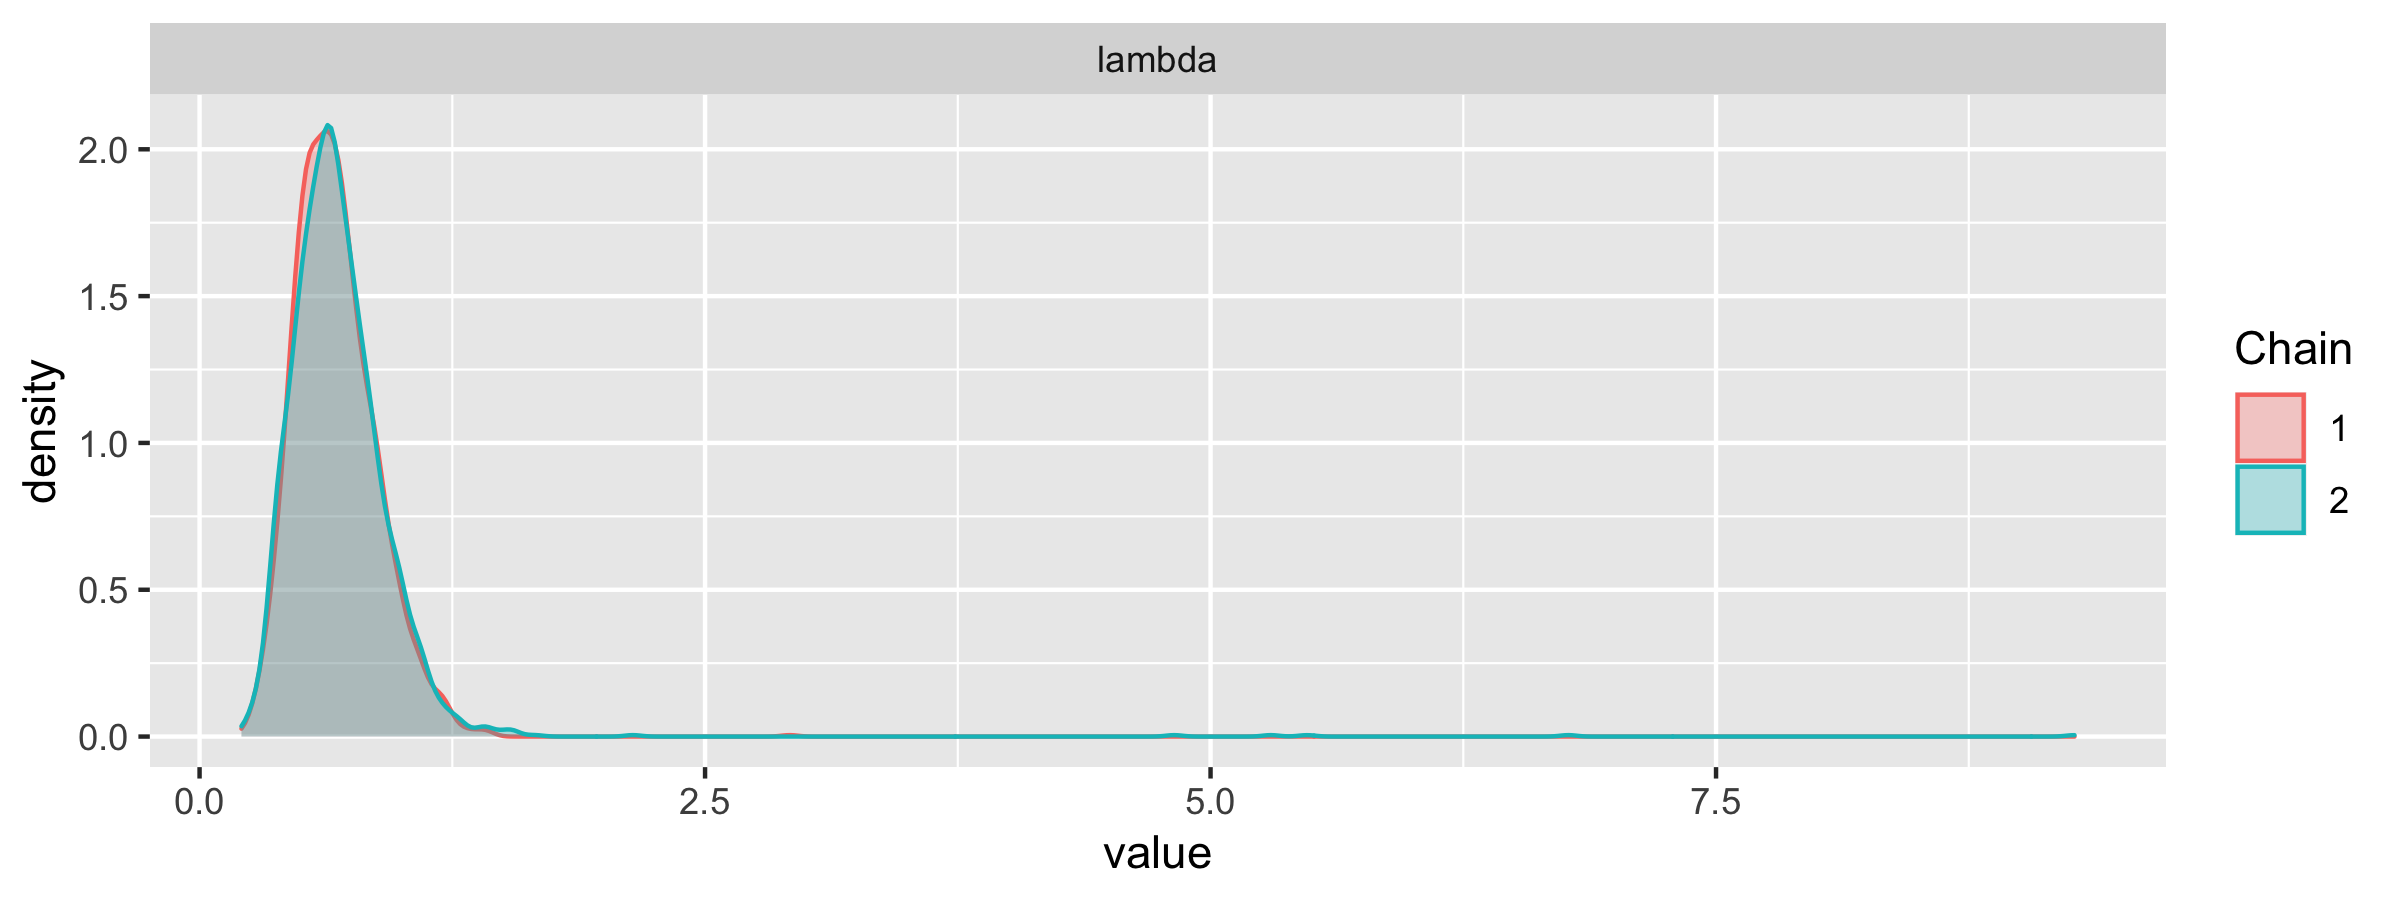

In [78]:
jags_df <- list(Y = c(1,2,3,4,3), N = 5)

bayesian_jags_object <- jags.model(textConnection(my_first_bayesian_jags_model), data = jags_df,
                                   n.chains = 2, inits = list(lambda = 10), n.adapt = 0)
#update(bayesian_jags_object, n.iter = 1000)
posterior_samples <- coda.samples(bayesian_jags_object, variable.names = c("lambda"), n.iter = 2000, thinning = 1)

ggs_density(ggs(posterior_samples))

The following is a bunch of commands to plot relevant quantities to check MCMC output:

#### Traceplot

The traceplot is useful since it allows you to check for convergence and correlation:gg

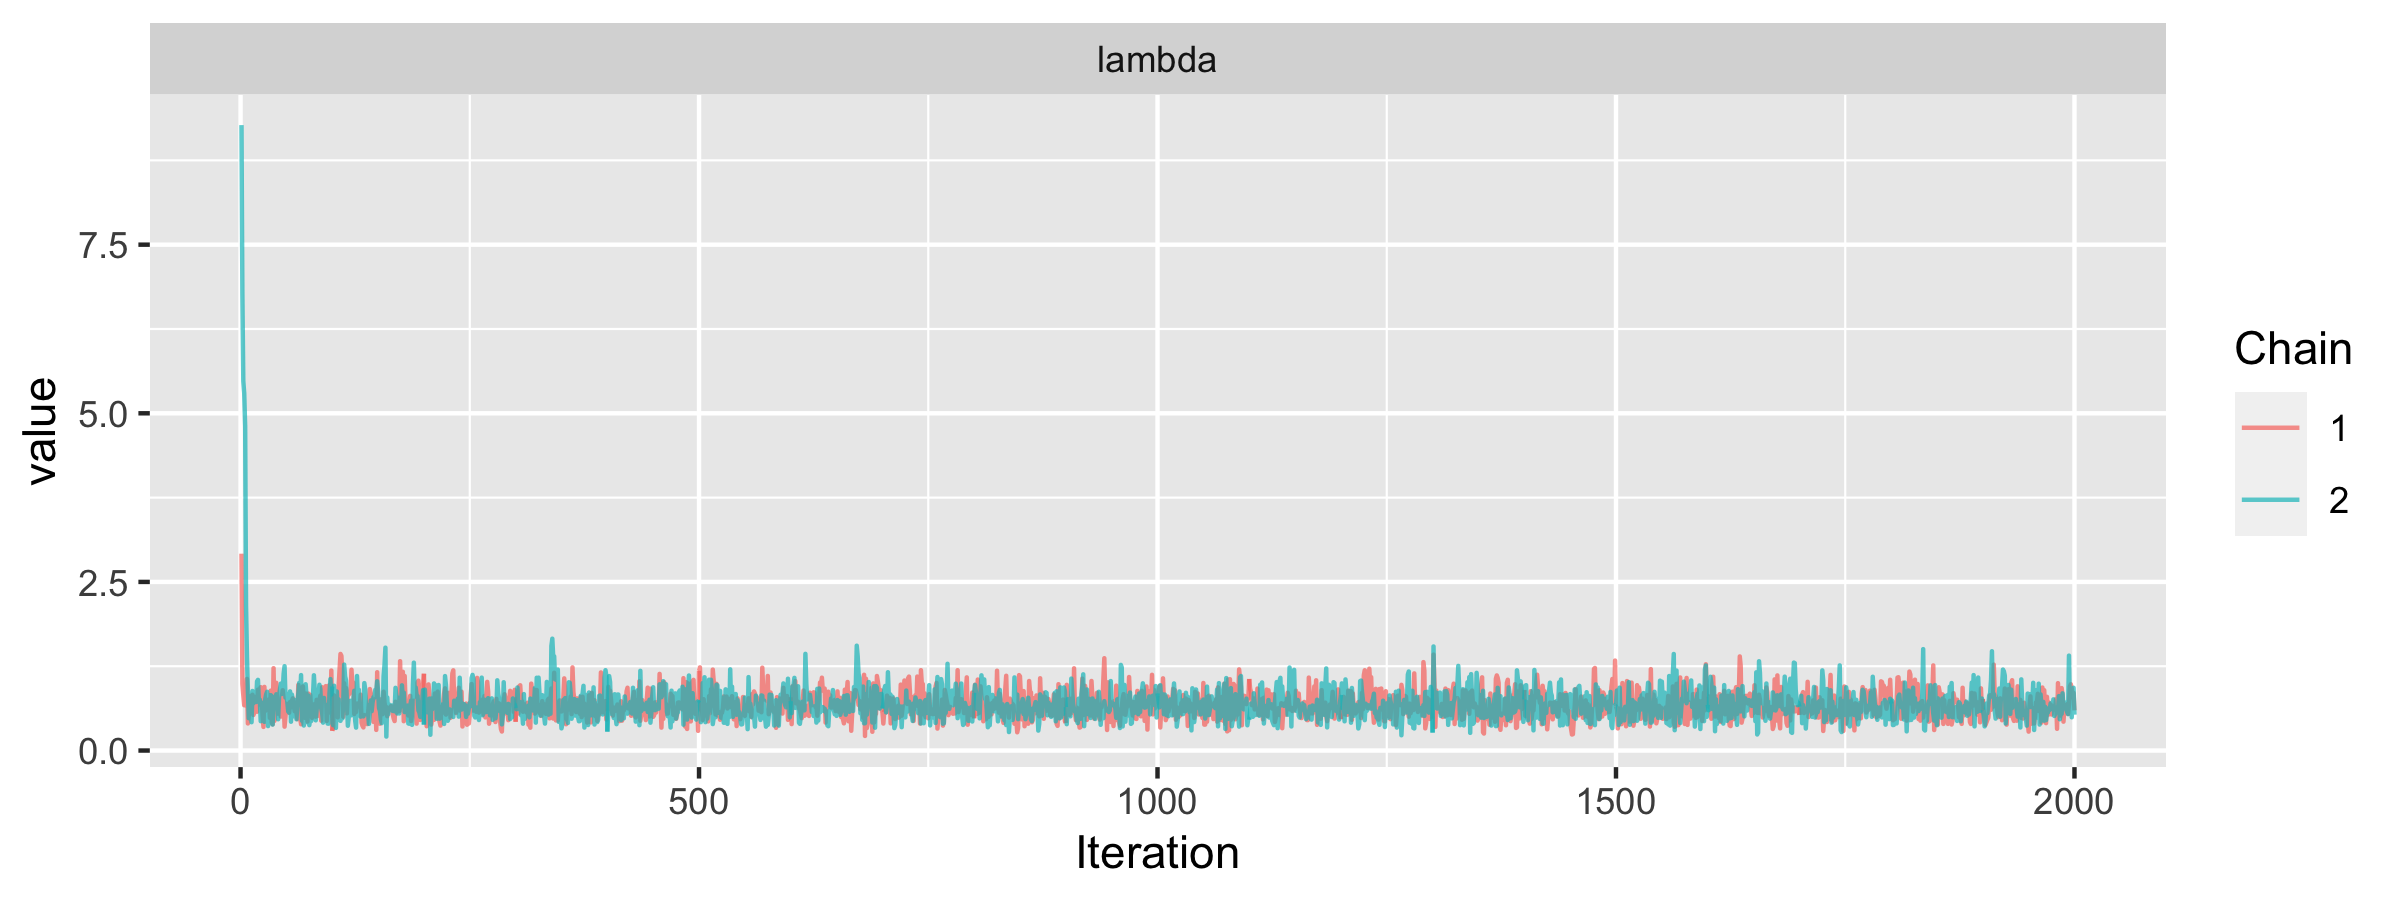

In [79]:
library(ggmcmc)

ggs_traceplot(ggs(posterior_samples))
# traceplot(posterior_samples) # coda code

#### Autocorrelation

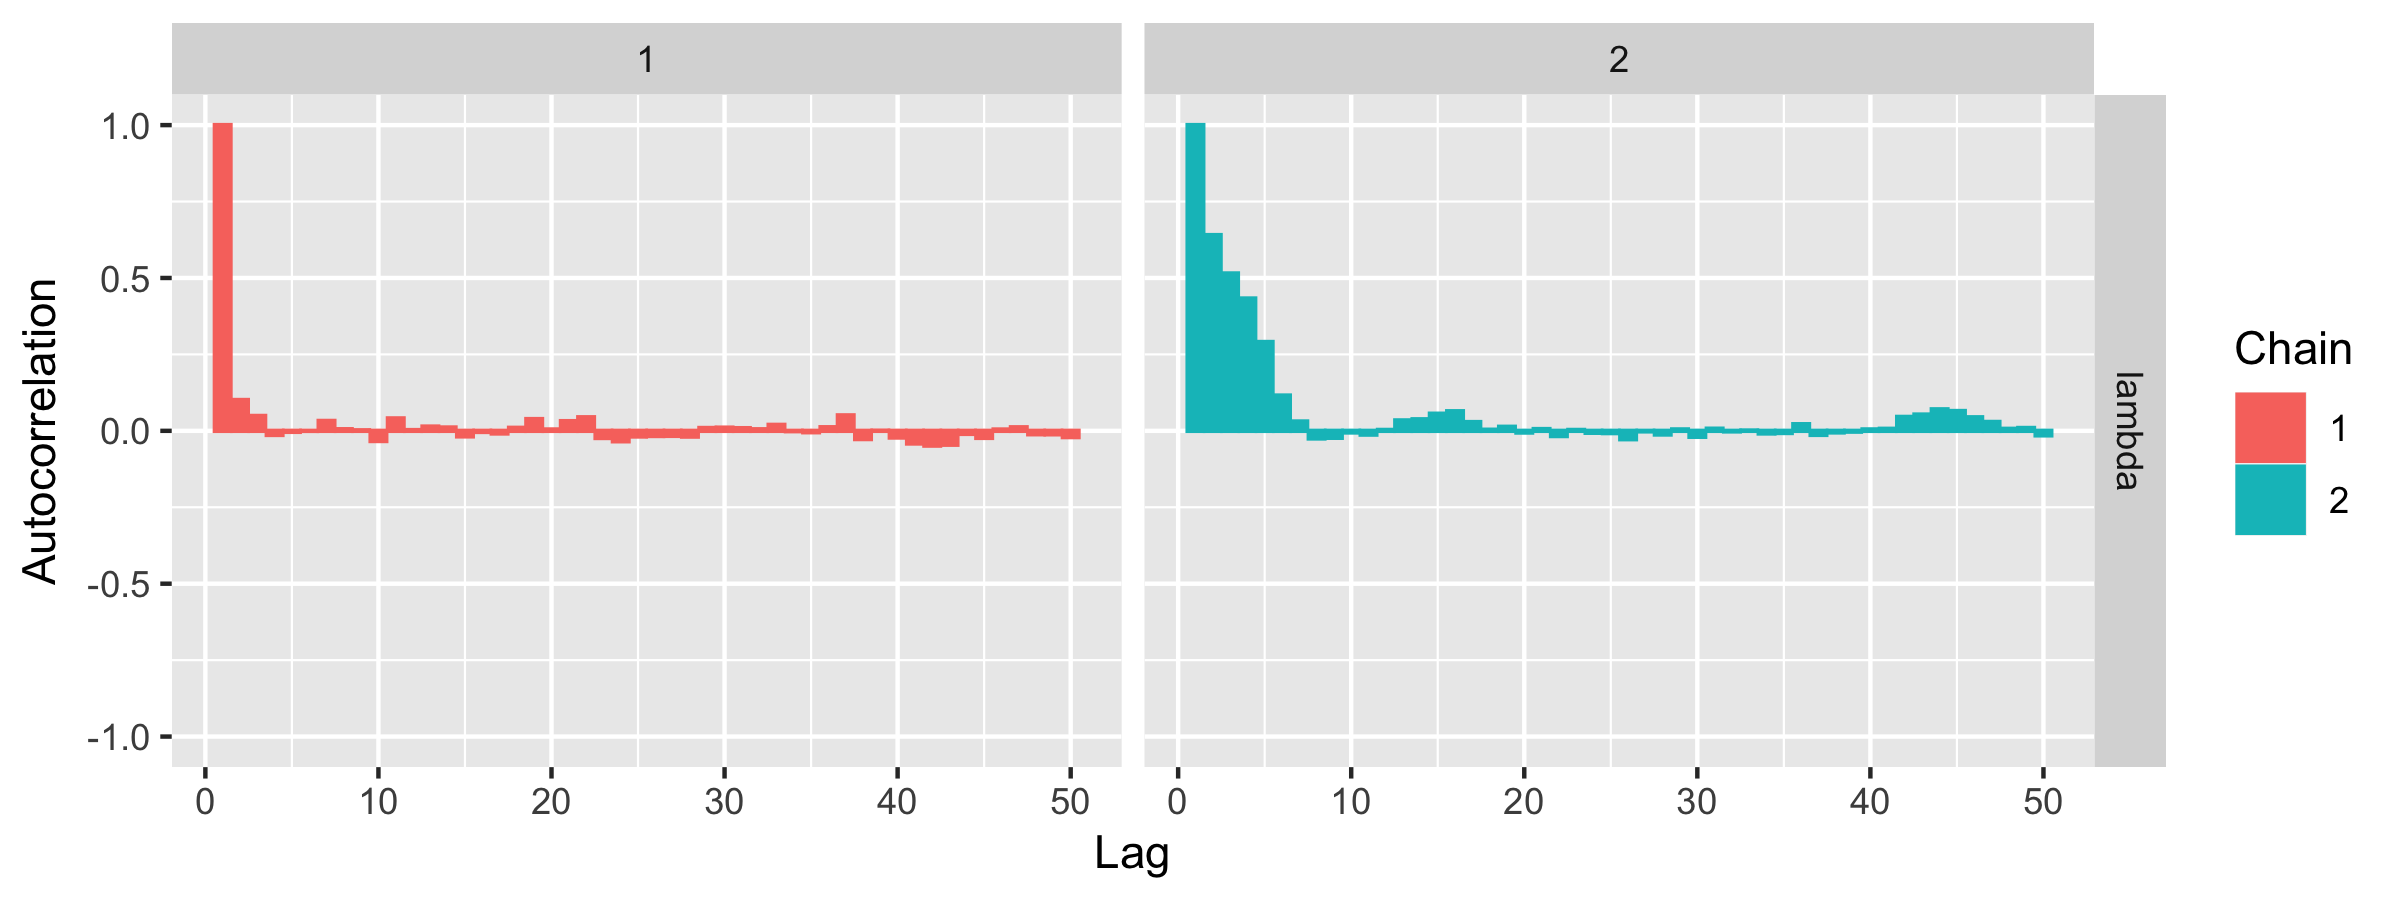

In [80]:
ggs_autocorrelation(ggs(posterior_samples))
# autocorr.plot(posterior_samples) # coda code

# base R code - includes line of significance (good for informing thinning)
# If multiple chains or multiple variables, must be called for each chain or variable
# acf(as.matrix(posterior_samples)) 

## 

## Example: Bayesian Inference of Handwritten Digits

In order to tie everything neatly together, we will consider a Bayesian inference example with real-world data: images of handwritten digits. This example demonstrates both how to work with matrices and multivariate data in ``JAGS`` and how modelling assumptions are critical in obtaining reasonable output.

The overall goal of this example is to "learn", using Bayesian inference, the distribution of handwritten digits, which are represented as $16\times 16$ pixel images. In order to perform Bayesian inference we need to posit an appropriate probability model for the distribution of hand written digits and a corresponding prior for the parameters of said probability model. 

In the following implementation we will be using "flattened" images which are represented by a length $256 = 16^2$ vector, instead of a $16\times 16$ grid. Let $Y \sim \mathbb{P}_\theta$ be a random handwritten image of a digit, where $\mathbb{P}_\theta$ is our probability model. Note that we are dealing with *multivariate* data and we have $Y = (Y^{(1)},Y^{(2)},\ldots,Y^{(256)})$. In the following we will observe multiple images $y_1, \ldots, y_n$ which are assumed to be IID realisations from random images $Y_1, \ldots, Y_n$. All of our observations put together, $\underline{y}$, form a matrix:

$$ \underline{y} =  (y_1,\ldots,y_n)^\top  = \begin{pmatrix} y_1^{(1)} & y_1^{(2)} & \ldots & y_1^{(256)} \\ y_2^{(1)} & y_2^{(2)} & \ldots & y_2^{(256)} \\ \vdots & \vdots & \ddots & \vdots \\ y_n^{(1)} & y_n^{(2)} & \ldots & y_n^{(256)} \end{pmatrix}.$$

Our final outcome is to summarise the posterior distribution $p(\theta | \underline{y})$ and to generate new images, conditional on our observations. That is, sample from the posterior predictive distribution $p(\tilde{y} | \underline{y})$.

### The Dataset

The dataset we will use is quite well-known and was used as the training set in a classic machine learning paper: "[Handwritten Digit Recognition with a Back-Propagation Network](https://papers.nips.cc/paper/1989/hash/53c3bce66e43be4f209556518c2fcb54-Abstract.html)" by LeCun et al.. The data is a set of normalised handwritten digits, automatically scanned from envelopes by the U.S. Postal Service. The original scanned digits were binary and of different sizes and orientations; the images here have been deslanted and size normalized, resulting in $16 \times 16$ grayscale image. The dataset also features the "true" value of the handwritten digit. It is, therefore, suitable for supervised classification, as was done in the LeCun et al. paper.

The data is supplied as a ``.RData`` file in the ``data`` subdirectory. Let's load the data as follows and take a look at the first few rows:

In [12]:
load('data/zip.train.RData')
data(zip.train)

head(zip.train, 5)

[,1] [,2] [,3] [,4] [,5]   [,6]   [,7]   [,8]   [,9]   [,10]  [,11] [,12] 
[1,] 6    -1   -1   -1   -1.000 -1.000 -1.000 -1.000 -0.631  0.862 ⋯      0.304
[2,] 5    -1   -1   -1   -0.813 -0.671 -0.809 -0.887 -0.671 -0.853 ⋯     -0.671
[3,] 4    -1   -1   -1   -1.000 -1.000 -1.000 -1.000 -1.000 -1.000 ⋯     -1.000
[4,] 7    -1   -1   -1   -1.000 -1.000 -0.273  0.684  0.960  0.450 ⋯     -0.318
[5,] 3    -1   -1   -1   -1.000 -1.000 -0.928 -0.204  0.751  0.466 ⋯      0.466
     [,13]  [,14]  [,15]  [,16]  [,17]  [,18]  [,19]  [,20]  [,21]
[1,]  0.823  1.000  0.482 -0.474 -0.991 -1.000 -1.000 -1.000 -1   
[2,] -0.671 -0.033  0.761  0.762  0.126 -0.095 -0.671 -0.828 -1   
[3,] -1.000 -1.000 -0.109  1.000 -0.179 -1.000 -1.000 -1.000 -1   
[4,]  1.000  0.536 -0.987 -1.000 -1.000 -1.000 -1.000 -1.000 -1   
[5,]  0.639  1.000  1.000  0.791  0.439 -0.199 -0.883 -1.000 -1

Each row of the ``zip.train`` corresponds to a different $16\times 16$ image. The first column corresponds to the digit drawn and the remaining $256$ columns correspond with the intensity values of the corresponding pixels.

In order to get a better understanding of the dataset it would be nice to display the images. We first need to munge a given row of the ``zip.train`` matrix into a form that is plottable. The following function ``zip2df`` does just that:

In [174]:
zip2df <- function(zip, row_number, digit = TRUE) {

    if (digit == TRUE) {
        print(paste("Number ", zip[row_number, ][1]))
        n_pixel_row <- sqrt(ncol(zip) - 1)
        z <- t(matrix(zip[row_number, ][-1], n_pixel_row, n_pixel_row, byrow = TRUE))
    }
    else{
        n_pixel_row <- sqrt(ncol(zip))
        z <- t(matrix(zip[row_number, ], n_pixel_row, n_pixel_row, byrow = TRUE))
    }

    x <- seq(1, n_pixel_row, length.out = n_pixel_row)
    y <- seq(n_pixel_row, 1, length.out = n_pixel_row)

    rownames(z) <- x
    colnames(z) <- y

    output <- as.data.frame(z) %>%
            rownames_to_column(var = "row") %>%
            gather(col, value, -row) %>%
            mutate(row = as.numeric(row), col = as.numeric(col))

    return(output)
}

The input variable ``digit`` is used to control whether the inputted matrix of pixel values (``zip``) has a leading column indicating the digit value drawn. That is, do we need to remove the first column or not.

Let's plot a few digits:

[1] "Number  6"


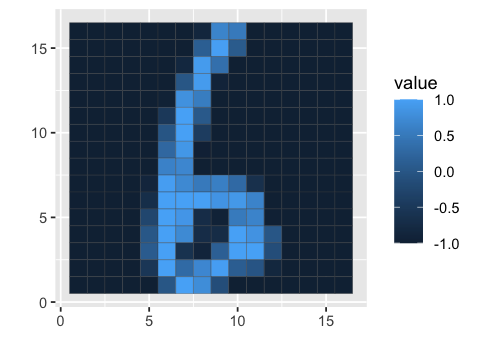

In [289]:
options(repr.plot.width = 4, repr.plot.height = 3)

ggplotdf <- zip2df(zip.train, row_number = 900)

plot <- ggplot(data = ggplotdf, aes(x = row, y = col, fill = value)) +
        geom_tile(colour = "grey30") + xlab("") + ylab("")
plot

From looking at a few images of the digits, it is quite clear that the underlying distribution of each of the digits is quite different: the images of the digit $1$ look very different to images of the digit $0$. Given that we are assuming IID data, in the following we will restrict ourselves to building probability models of each of the digits, instead of all of them at once. That is, in our previous notation, $Y \sim \mathbb{P}_\theta$ will be a random image of the digit $k$, where $k = 0, 1, \ldots, 9$:

In [269]:
N_digits <- 40

one_data <- zip.train[zip.train[, 1] == 1, -1]
one_data <- one_data[1:N_digits, ]

two_data <- zip.train[zip.train[, 1] == 2, -1]
two_data <- two_data[1:N_digits, ]

eight_data <- zip.train[zip.train[, 1] == 8, -1]
eight_data <- eight_data[1:N_digits, ]

zero_data <- zip.train[zip.train[, 1] == 0, -1]
zero_data <- zero_data[1:N_digits, ]

We will also only use a few observations from ``zip.train``. This is mainly due to the computational issues. ``JAGS`` is probably unsuitable for such high dimensional and large number of data situations. 

Also, note that you can probably use more advanced models to cope with using all digits at once (e.g. [mixture models](https://en.wikipedia.org/wiki/Mixture_model)).

### Independent Beta Model

Since the each of the pixels vary in intensity from $-1$ to $1$, a first try of a model would be to use a probability distribution that is defined over an interval. Since the Beta distribution is defined over the interval $[0,1]$, it seems like a suitable starting point. In order to use the Beta distribution, we will have to re-normalise each pixel intensity to be restricted on $[0,1]$ instead of $[-1,1]$ using a tranformation.

A priori, you would naturally expect each pixel intensity (now normalised to be in $[0,1]$), to be very close to $0$ or very close to $1$. This is because each pixel will either clearly be part of the drawn digit or not. 

You can incorporate this knowledge into our prior distribution by assuming the shape parameters $\alpha$ and $\beta$ of our Beta distribution are less than one:

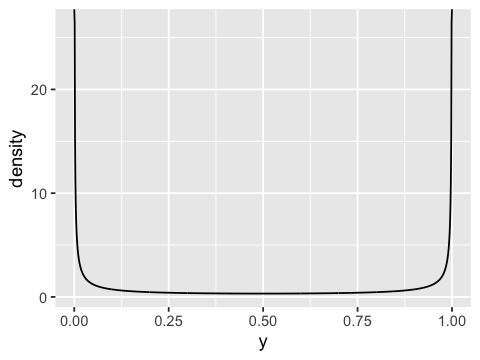

In [60]:
alpha <- 0.2
beta <- 0.2

mesh <- seq(0, 1, length.out = 1000)
beta_plot_df <- data.frame(y = mesh, density = dbeta(mesh, alpha, beta))

beta_density_plot <- ggplot(beta_plot_df, aes(x = y, y = density)) +
                       geom_line()
beta_density_plot

For our first probability model, therefore, let us assume that each pixel $Y_i^{(j)}$ from a random image $Y_i = (Y_i^{(1)},\ldots,Y_i^{(256)})$ are all independently Beta distributed. We will also assume a Beta prior for the parameters (since we wanted the shape parameters $\alpha < 1$ and $\beta<1$). Let's write our model in math first, before using ``JAGS``:

1. $Y_i = (Y_i^{(1)},\ldots,Y_i^{(256)}$ and each $Y_i^{(j)} \sim \text{Beta}(\alpha_j, \beta_j)$ independently.
2. Each $\alpha_j \sim \text{Beta}(1,3)$ and $\beta_j \sim \text{Beta}(3,1)$.

#### Sampling from the Prior Model

Let's first generate a few images from our prior model, before conditioning on data. We will do this by writing a ``JAGS`` program:

In [73]:
prior_beta_model <- "
    model{
        for (i in 1:256) {
            Y[i] ~ dbeta(alpha[i], beta[i])
            alpha[i] ~ dbeta(1, 3)
            beta[i] ~ dbeta(3, 1)
        }
    }
    "

And then running it:

In [74]:
jags_prior_beta_model <- jags.model(textConnection(prior_beta_model))
y_prior_samples <- coda.samples(jags_prior_beta_model, variable.names = c("Y"), n.iter = 1000)
y_prior_matrix <- as.matrix(y_prior_samples)
head(y_prior_matrix, 3)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 0
   Unobserved stochastic nodes: 768
   Total graph size: 770

Initializing model



Y[1]         Y[2]      Y[3]       Y[4]         Y[5]         Y[6]        
[1,] 0.0706589690 0.2810178 0.24017580 5.333297e-01 7.117147e-01 7.411135e-01
[2,] 0.0001077685 0.1288966 0.02860836 1.571619e-01 2.562409e-02 1.120335e-05
[3,] 0.4115364500 0.8425878 0.79940315 1.108365e-49 1.187820e-15 1.964780e-10
     Y[7]         Y[8]         Y[9]         Y[10]     ⋯ Y[247]      
[1,] 0.0731957050 1.413253e-05 3.847810e-13 0.7854975 ⋯ 1.898964e-30
[2,] 0.5119163155 5.205991e-01 2.199358e-01 0.5051016 ⋯ 4.738066e-01
[3,] 0.0009421423 8.258638e-20 4.977943e-03 0.1617470 ⋯ 1.223587e-01
     Y[248]       Y[249]    Y[250]       Y[251]       Y[252]       Y[253]      
[1,] 9.726065e-01 0.2078103 0.0404604249 3.637691e-01 7.156899e-06 1.005468e-23
[2,] 8.344908e-06 0.9257744 0.1452743587 1.161359e-01 1.761487e-01 2.124602e-02
[3,] 5.534521e-15 0.2345299 0.0001677795 1.090312e-27 9.994417e-01 1.364315e-02
     Y[254]       Y[255]       Y[256]      
[1,] 1.542971e-06 6.171282e-19 1.021888e-29
[2,] 9.262986e-01 1.116861e-01 3.269757e-63
[3,] 9.401863e-01 3.643225e-01 2.798752e-03

We have now generated $1000$ samples from the prior predictive model. Let's plot a few images to see what our prior model is assuming:

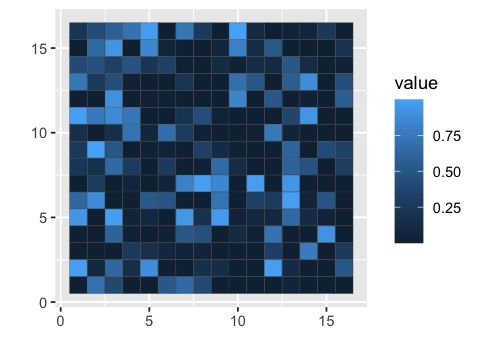

In [75]:
options(repr.plot.width = 4, repr.plot.height = 3)

ggplotdf <- zip2df(y_prior_matrix, 90, FALSE)

plot <- ggplot(data = ggplotdf, aes(x = row, y = col, fill = value)) +
        geom_tile(colour = "grey30") + xlab("") + ylab("")
plot

#### ``JAGS`` Implementation

Let's now write up our full model as a ``JAGS`` program:

In [71]:
beta_model <- "
    model{
        for (i in 1:N) {
            for (j in 1:256) {
                Y[i, j] ~ dbeta(alpha[j], beta[j])
            }
        }

        for (j in 1:256) {
            alpha[j] ~ dbeta(1, 3)
            beta[j] ~ dbeta(3, 1)
        }

        for (j in 1:256) {
            Y_pred[j] ~ dbeta(alpha[j], beta[j])
        }
    }
    "

Let's now compile a ``JAGS`` model for each of our datasets (for me, this took about $15$ seconds per model):

In [76]:
jags_beta_model_ones <- jags.model(textConnection(beta_model), data = list(Y = one_data / 2.01 + 1/2, N = nrow(one_data)))
jags_beta_model_twos <- jags.model(textConnection(beta_model), data = list(Y = two_data / 2.01 + 1/2, N = nrow(two_data)))
jags_beta_model_eights <- jags.model(textConnection(beta_model), data = list(Y = eight_data / 2.01 + 1/2, N = nrow(eight_data)))
jags_beta_model_zeros <- jags.model(textConnection(beta_model), data = list(Y = zero_data / 2.01 + 1/2, N = nrow(zero_data)))

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 7680
   Unobserved stochastic nodes: 768
   Total graph size: 8451

Initializing model

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 7680
   Unobserved stochastic nodes: 768
   Total graph size: 8451

Initializing model

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 7680
   Unobserved stochastic nodes: 768
   Total graph size: 8451

Initializing model

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 7680
   Unobserved stochastic nodes: 768
   Total graph size: 8451

Initializing model



Let's sample from the predictive distribution for each of our models. The following takes me about $30$ seconds per model:

In [87]:
update(jags_beta_model_ones, n.iter = 1000)
y_pred_samples_ones <- coda.samples(jags_beta_model_ones, variable.names = c("Y_pred"), n.iter = 1000)
y_pred_matrix_ones <- as.matrix(y_pred_samples_ones)

update(jags_beta_model_twos, n.iter = 1000)
y_pred_samples_twos <- coda.samples(jags_beta_model_twos, variable.names = c("Y_pred"), n.iter = 1000)
y_pred_matrix_twos <- as.matrix(y_pred_samples_twos)

update(jags_beta_model_eights, n.iter = 1000)
y_pred_samples_eights <- coda.samples(jags_beta_model_eights, variable.names = c("Y_pred"), n.iter = 1000)
y_pred_matrix_eights <- as.matrix(y_pred_samples_eights)

update(jags_beta_model_zeros, n.iter = 1000)
y_pred_samples_zeros <- coda.samples(jags_beta_model_zeros, variable.names = c("Y_pred"), n.iter = 1000)
y_pred_matrix_zeros <- as.matrix(y_pred_samples_zeros)

Let's plot some output:

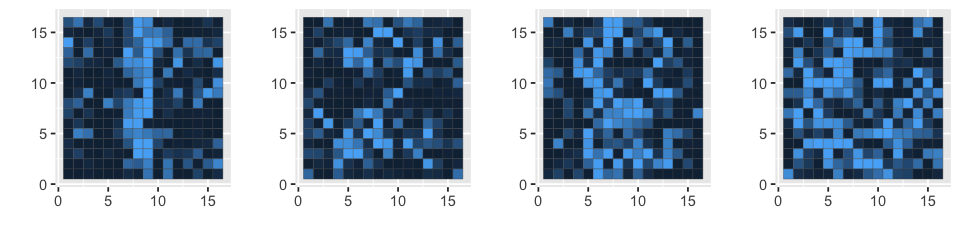

In [106]:
options(repr.plot.width = 8, repr.plot.height = 2)

row_number <- 30

ggplotdf <- zip2df(y_pred_matrix_ones, row_number, FALSE)

plot_ones <- ggplot(data = zip2df(y_pred_matrix_ones, row_number, FALSE), aes(x = row, y = col, fill = value)) +
             geom_tile(colour = "grey30") + xlab("") + ylab("") + theme(legend.position = "none") 
plot_twos <- ggplot(data = zip2df(y_pred_matrix_twos, row_number, FALSE), aes(x = row, y = col, fill = value)) +
             geom_tile(colour = "grey30") + xlab("") + ylab("") + theme(legend.position = "none") 
plot_eights <- ggplot(data = zip2df(y_pred_matrix_eights, row_number, FALSE), aes(x = row, y = col, fill = value)) +
               geom_tile(colour = "grey30") + xlab("") + ylab("") + theme(legend.position = "none") 
plot_zeros <- ggplot(data = zip2df(y_pred_matrix_zeros, row_number, FALSE), aes(x = row, y = col, fill = value)) +
              geom_tile(colour = "grey30") + xlab("") + ylab("") + theme(legend.position = "none") 

plot_grid(plot_ones, plot_twos, plot_eights, plot_zeros, nrow = 1)

This seemed to work okay for the number one, and at least some of the samples of the other digits were recognisable! Try to pick out some flaws in this model.

### Multivariate Normal Model

A key assumption of the last model was the independence between pixel intensities. In reality, images have dependencies between pixel values that are close to each other. For example, if the image is of the number $1$, it is quite likely that the pixels above and beneath a given pixel are of the same value (positive correlation). Furthermore, a pixel on the boundary of a digit will likely have an adjacent pixel of opposite value (negative correlation). 

The simplest probability model that allows for such dependencies is the multivariate normal distribution. Therefore, for our next and final model, we will assume that a random image is generated according to a multivariate normal distribution: 

$$Y_i \sim \text{MultivariateNormal}(\underline{\mu}, \Sigma),$$

where $\underline{\mu} = (\mu_1,\mu_2,\ldots,\mu_{256})^\top$ is the mean vector of pixel intensities and 

$$ \Sigma = \begin{pmatrix} C_{1,1} & C_{1,2} & \ldots & C_{1,256} \\ C_{2,1} & C_{2,2} & \ldots & C_{2,256}  \\ \vdots & \vdots & \ddots & \vdots \\ C_{256,1} & C_{256,2} & \ldots & C_{256,256}   \end{pmatrix} $$

is the covariance matrix specifying the dependencies between each pixel. Here, $C_{i,j}$ denotes the covariance between the $i\text{th}$ and $j\text{th}$ pixel and the diagonal elements $C_{i,i}$ are the variance of the $i\text{th}$ pixel. As we have discussed previously (refer to ``Problem_1.ipynb`` in "Problem 1: Conjugate Inference"), the covariance is directly related to correlation via the formula:

$$ \text{Corr}(Y^{(i)}, Y^{(j)}) = \frac{\text{Cov}(Y^{(i)}, Y^{(j)})}{\sqrt{\text{Var}(Y^{(i)})\text{Var}(Y^{(j)})}}. $$

In order to perform Bayesian inference of the parameters $\underline{\mu}$ and $\Sigma$, we need to specify valid priors. The only difficulty here is how to specify an appropriate prior for the distribution of a covariance matrix. A valid covariance matrix must be both [symmetric](https://en.wikipedia.org/wiki/Symmetric_matrix#:~:text=In%20linear%20algebra%2C%20a%20symmetric,respect%20to%20the%20main%20diagonal.) and [positive semi-definite](https://en.wikipedia.org/wiki/Definite_matrix) and these two requirements make naive approaches untenable. 

It turns out that an appropriate distribution is the [Wishart distribution](https://en.wikipedia.org/wiki/Wishart_distribution). The Wishart distribution is a multivariate generalisation of the [Gamma distribution](https://en.wikipedia.org/wiki/Gamma_distribution). The Gamma distribution is a conjugate prior for the precision (1 / variance) of the normal distribution. Similarly, the Wishart distribution is a conjugate prior for the precision matrix (inverse of covariance matrix) of a multivariate normal distribution.

Our full Bayesian model is as follows:

1. $Y_i \sim \text{MultivariateNormal}(\underline{\mu},\Sigma)$.
2. $\Sigma^{-1} \sim \text{Wishart}(R, d)$. $\Sigma^{-1}$ is a precision matrix (inverse of covariance matrix).
3. $\underline{\mu} \sim \text{MultivariateNormal}(\underline{0}, \Sigma)$.
4. $R = 0.1 I_{256}$ and $d = 400$.

Specifying an appropriate Wishart prior for the precision matrix is difficult, as a first attempt we will set $R$ as the identity matrix multiplied by $0.1$ and $d=400$. Our chosen prior for both $\mu$ and $\Sigma^{-1}$ is actually a [conjugate prior](https://en.wikipedia.org/wiki/Conjugate_prior#Table_of_conjugate_distributions), so we could follow our methodology used in "Problem 1: Conjugate Inference". We will, however, use ``JAGS``.

#### Sampling from the Prior Model
 
Let's first sample from our prior model, to visualise our modelling assumptions:

In [285]:
prior_mvn_model <- "
    model{
        Y ~ dmnorm(mu, inv_sigma)

        for (i in 1:256) {
            R_matrix[i, i] = 0.1
            for (j in (i+1):256) {
                R_matrix[i, j] = 0
                R_matrix[j, i] = 0
            }
        }

        inv_sigma ~ dwish(R_matrix, 400)
        mu ~ dmnorm(rep(0,256), inv_sigma)
    }
    "

Let's run the ``JAGS`` program:

In [286]:
jags_prior_mvn_model <- jags.model(textConnection(prior_mvn_model))
mvn_prior_samples <- coda.samples(jags_prior_mvn_model, variable.names = c("Y", "inv_sigma"), n.iter = 100)
mvn_prior_matrix <- as.matrix(mvn_prior_samples)
head(mvn_prior_matrix, 3)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 0
   Unobserved stochastic nodes: 3
   Total graph size: 9

Initializing model



Y[1]        Y[2]        Y[3]        Y[4]         Y[5]        Y[6]       
[1,] -0.01783114  0.02072557 -0.06697353 -0.004684886 0.008307480 0.044161469
[2,]  0.02603041 -0.01373038  0.03558220 -0.053037807 0.026926994 0.009947938
[3,]  0.03837939 -0.04719031 -0.02256184  0.021249923 0.007232473 0.002925161
     Y[7]          Y[8]         Y[9]        Y[10]       ⋯ inv_sigma[247,256]
[1,] -0.0310987470  0.006870040  0.02581743 -0.02769734 ⋯  15.84395         
[2,]  0.0002248547 -0.005689723  0.02080192 -0.09049096 ⋯  28.80518         
[3,] -0.0859282944  0.018849380 -0.01609103 -0.03709570 ⋯ -23.55832         
     inv_sigma[248,256] inv_sigma[249,256] inv_sigma[250,256]
[1,] -16.619448          179.00200         -364.49331        
[2,] -84.706335          -13.02898           71.91245        
[3,]  -5.840334         -269.89430         -250.55255        
     inv_sigma[251,256] inv_sigma[252,256] inv_sigma[253,256]
[1,]  301.7449          -117.613656        -33.60894         
[2,] -115.2856             8.318305        171.38994         
[3,]   88.3512          -118.816562        266.41434         
     inv_sigma[254,256] inv_sigma[255,256] inv_sigma[256,256]
[1,]  23.95352           13.33847          4221.050          
[2,]  15.91646          -44.60470          4008.301          
[3,] 364.03966           66.72355          4350.104

Let's samples from the prior predictive model:

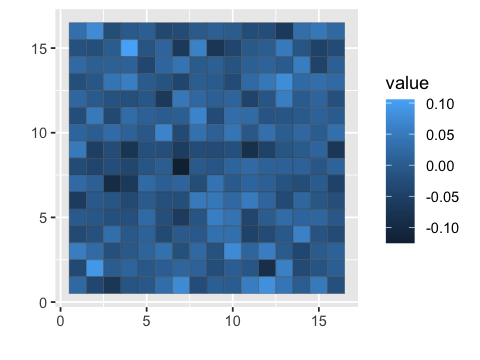

In [287]:
options(repr.plot.width = 4, repr.plot.height = 3)

ggplotdf <- zip2df(mvn_prior_matrix[, 1:256], 90, FALSE)

plot <- ggplot(data = ggplotdf, aes(x = row, y = col, fill = value)) +
        geom_tile(colour = "grey30") + xlab("") + ylab("")
plot

Let's look at prior samples of the covariance matrix. We will plot the covariance matrix using the ``zip2df`` function with the intensity of the pixel value corresponding to the size of the covariance. Recall that samples from the Wishart distribution will be valid precision matrices, so to plot *covariance* matrices we use the ``R`` function ``solve`` to perform a matrix inverse.

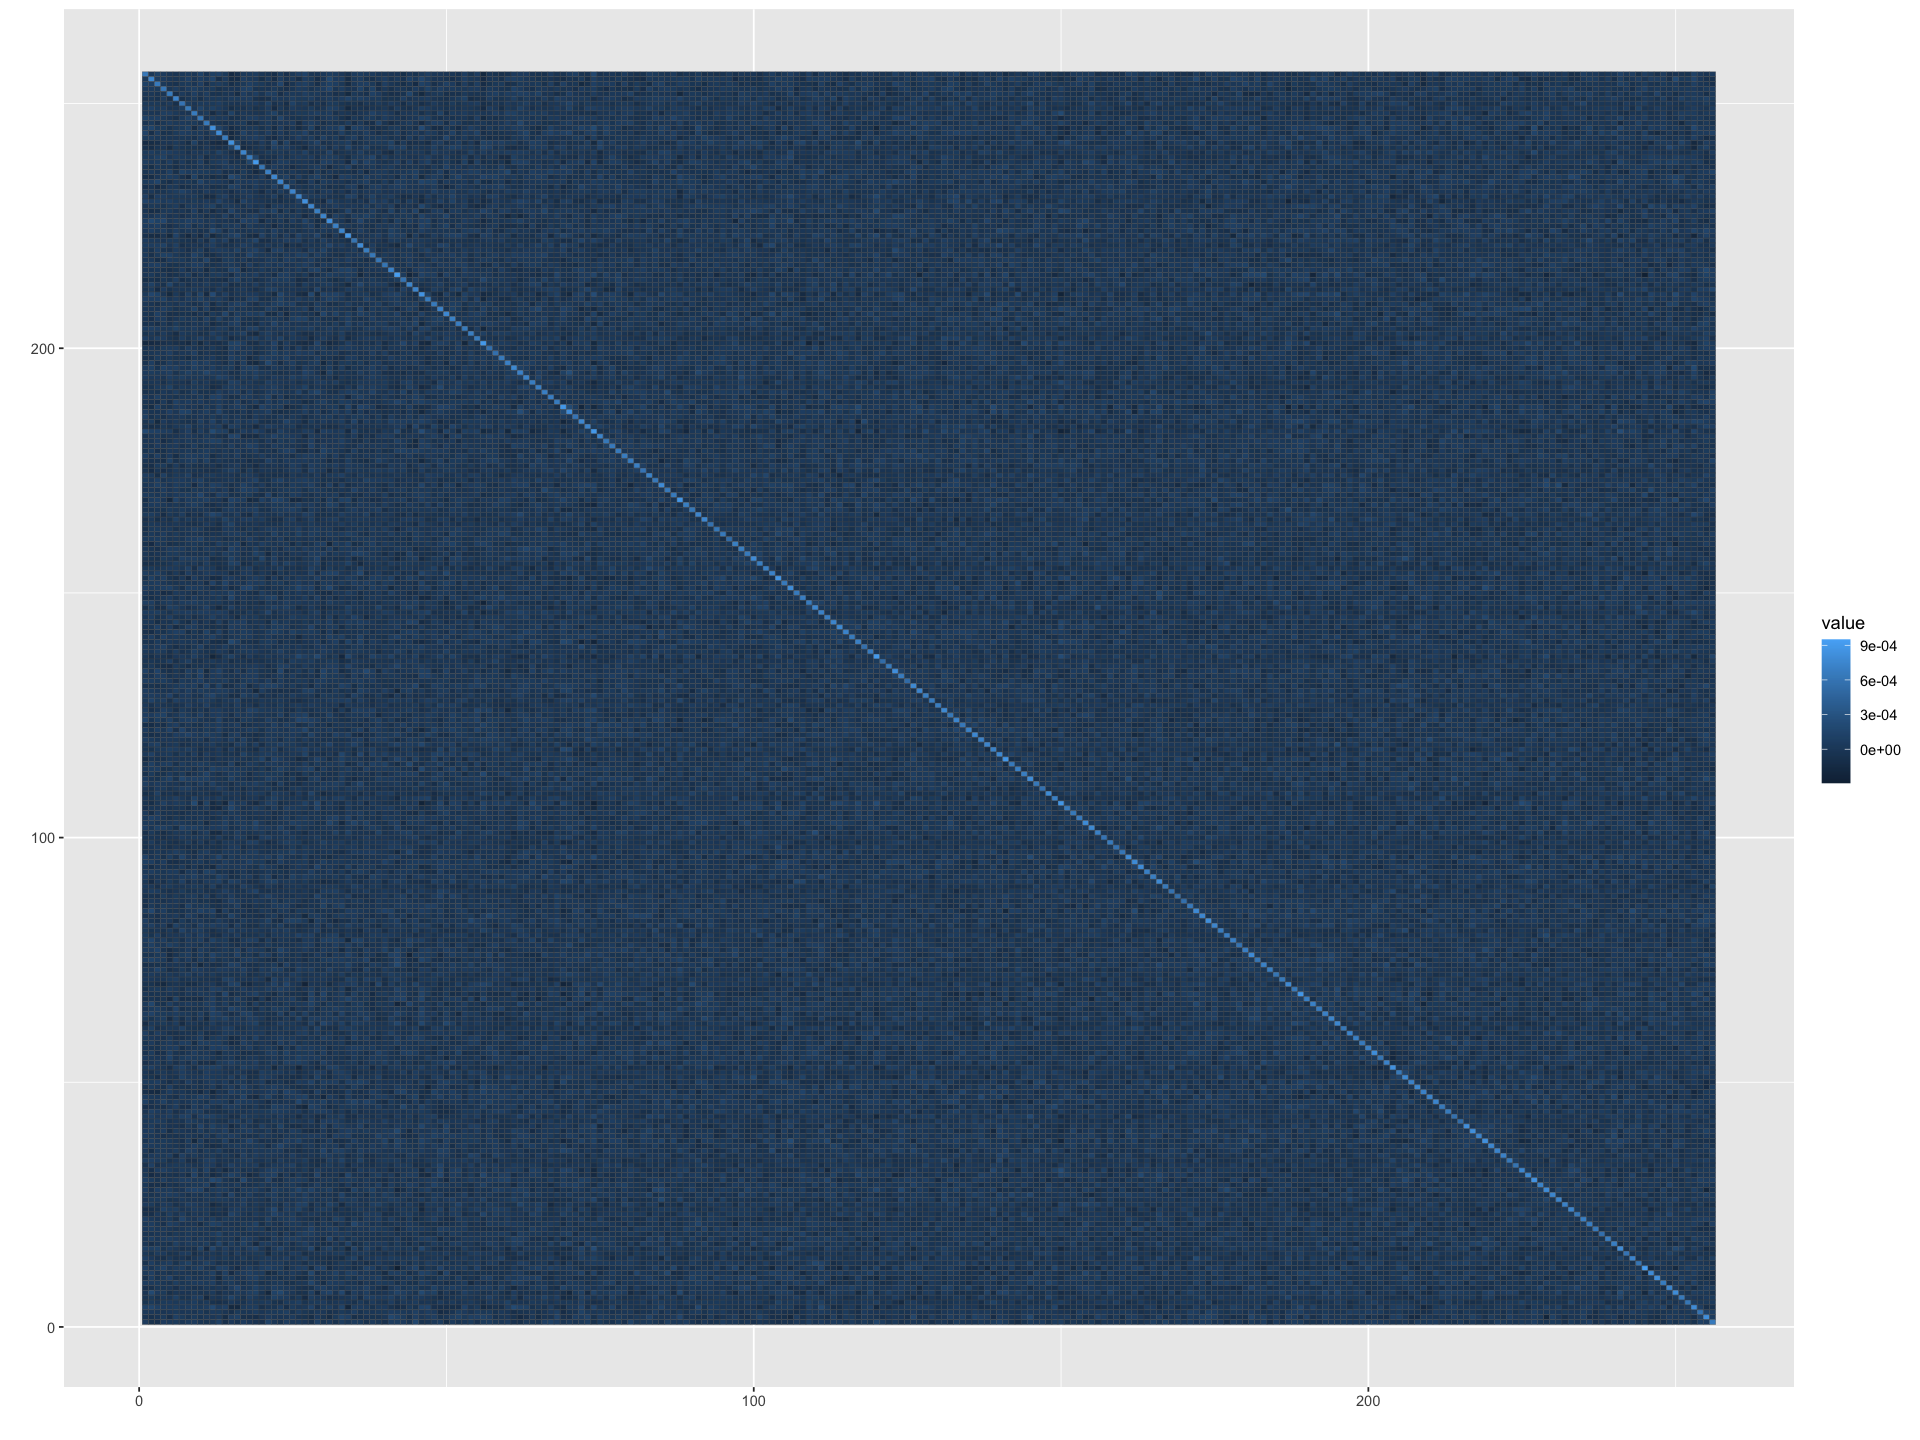

In [288]:
options(repr.plot.width = 16, repr.plot.height = 12)

sample_number <- 90
ggplotdf <- zip2df(matrix(solve(matrix(mvn_prior_matrix[sample_number, 257:65792], nrow = 256)), nrow=1), 1, FALSE)

plot <- ggplot(data = ggplotdf, aes(x = row, y = col, fill = value)) +
        geom_tile(colour = "grey30") + xlab("") + ylab("")
plot

#### ``JAGS`` implementation

Let's implement the full multivariate normal model as a ``JAGS`` program:

In [290]:
mvn_model <- "
    model{
        for (i in 1:N) {
            Y[i, ] ~ dmnorm(mu, inv_sigma)
        }

        for (i in 1:256) {
            R_matrix[i, i] = 0.1
            for (j in (i+1):256) {
                R_matrix[i, j] = 0
                R_matrix[j, i] = 0
            }
        }

        inv_sigma ~ dwish(R_matrix, 400)
        mu ~ dmnorm(rep(0,256), inv_sigma)

        Y_pred ~ dmnorm(mu, inv_sigma)
    }
    "

Let's now compile a ``JAGS`` model for each of our datasets:

In [271]:
jags_mvn_model_ones <- jags.model(textConnection(mvn_model), data = list(Y = one_data, N = nrow(one_data)))
jags_mvn_model_twos <- jags.model(textConnection(mvn_model), data = list(Y = two_data, N = nrow(two_data)))
jags_mvn_model_eights <- jags.model(textConnection(mvn_model), data = list(Y = eight_data, N = nrow(eight_data)))
jags_mvn_model_zeros <- jags.model(textConnection(mvn_model), data = list(Y = zero_data, N = nrow(zero_data)))

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 40
   Unobserved stochastic nodes: 3
   Total graph size: 50

Initializing model

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 40
   Unobserved stochastic nodes: 3
   Total graph size: 50

Initializing model

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 40
   Unobserved stochastic nodes: 3
   Total graph size: 50

Initializing model

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 40
   Unobserved stochastic nodes: 3
   Total graph size: 50

Initializing model



Let's sample from the predictive distribution for each of our ``JAGS`` objects (this takes me about $23$ seconds for each model):

In [272]:
update(jags_mvn_model_ones, n.iter = 300)
y_mvn_pred_samples_ones <- coda.samples(jags_mvn_model_ones, variable.names = c("Y_pred", "inv_sigma"), n.iter = 300)
y_mvn_pred_matrix_ones <- as.matrix(y_mvn_pred_samples_ones)

update(jags_mvn_model_twos, n.iter = 300)
y_mvn_pred_samples_twos <- coda.samples(jags_mvn_model_twos, variable.names = c("Y_pred",  "inv_sigma"), n.iter = 300)
y_mvn_pred_matrix_twos <- as.matrix(y_mvn_pred_samples_twos)

update(jags_mvn_model_eights, n.iter = 300)
y_mvn_pred_samples_eights <- coda.samples(jags_mvn_model_eights, variable.names = c("Y_pred", "inv_sigma"), n.iter = 300)
y_mvn_pred_matrix_eights <- as.matrix(y_mvn_pred_samples_eights)

update(jags_mvn_model_zeros, n.iter = 300)
y_mvn_pred_samples_zeros <- coda.samples(jags_mvn_model_zeros, variable.names = c("Y_pred", "inv_sigma"), n.iter = 300)
y_mvn_pred_matrix_zeros <- as.matrix(y_mvn_pred_samples_zeros)

Let's plot some output:

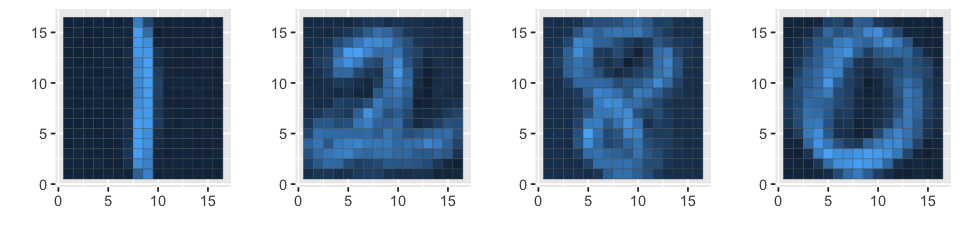

In [278]:
options(repr.plot.width = 8, repr.plot.height = 2)

row_number <- 200

ggplotdf <- zip2df(y_pred_matrix_ones, row_number, FALSE)

plot_ones <- ggplot(data = zip2df(y_mvn_pred_matrix_ones[, 1:256], row_number, FALSE), aes(x = row, y = col, fill = value)) +
             geom_tile(colour = "grey30") + xlab("") + ylab("") + theme(legend.position = "none") 
plot_twos <- ggplot(data = zip2df(y_mvn_pred_matrix_twos[, 1:256], row_number, FALSE), aes(x = row, y = col, fill = value)) +
             geom_tile(colour = "grey30") + xlab("") + ylab("") + theme(legend.position = "none") 
plot_eights <- ggplot(data = zip2df(y_mvn_pred_matrix_eights[, 1:256], row_number, FALSE), aes(x = row, y = col, fill = value)) +
               geom_tile(colour = "grey30") + xlab("") + ylab("") + theme(legend.position = "none") 
plot_zeros <- ggplot(data = zip2df(y_mvn_pred_matrix_zeros[, 1:256], row_number, FALSE), aes(x = row, y = col, fill = value)) +
              geom_tile(colour = "grey30") + xlab("") + ylab("") + theme(legend.position = "none") 

plot_grid(plot_ones, plot_twos, plot_eights, plot_zeros, nrow = 1)

This seemed to do better, indicating the inclusion of dependencies was important. 

As a final check, let's visualise posterior samples of the covariance matrix.

#### Covariance Structure of the Images of $1$

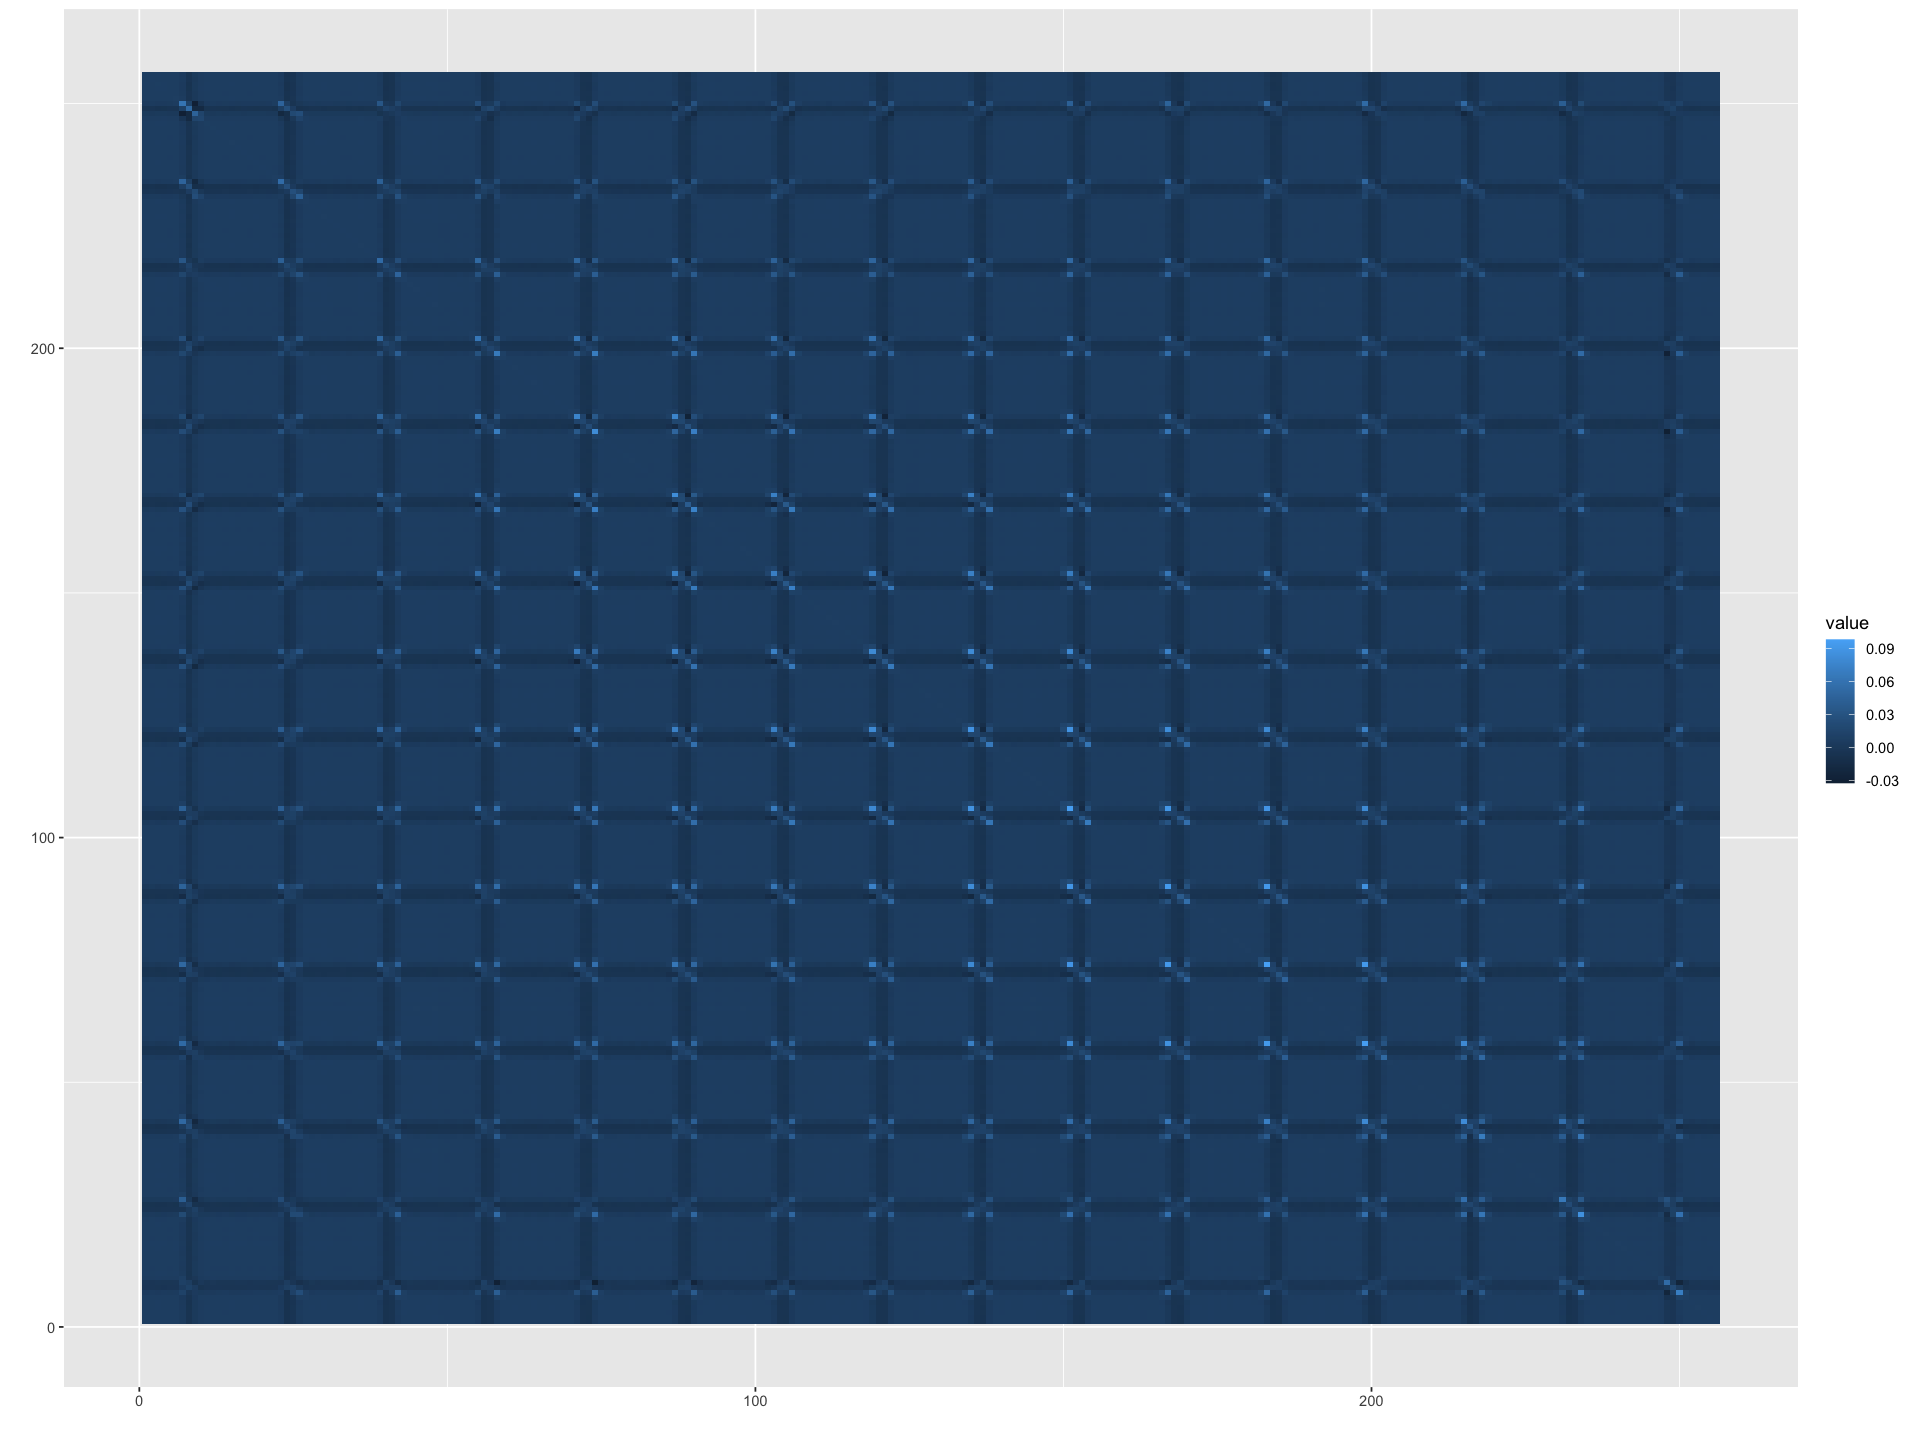

In [279]:
options(repr.plot.width = 16, repr.plot.height = 12)

ggplotdf <- zip2df(matrix(solve(matrix(y_mvn_pred_matrix_ones[row_number, 257:65792], nrow = 256)), nrow=1), 1, FALSE)

plot <- ggplot(data = ggplotdf, aes(x = row, y = col, fill = value)) +
        geom_tile() + xlab("") + ylab("")
plot

#### Covariance Structure of the Images of $8$

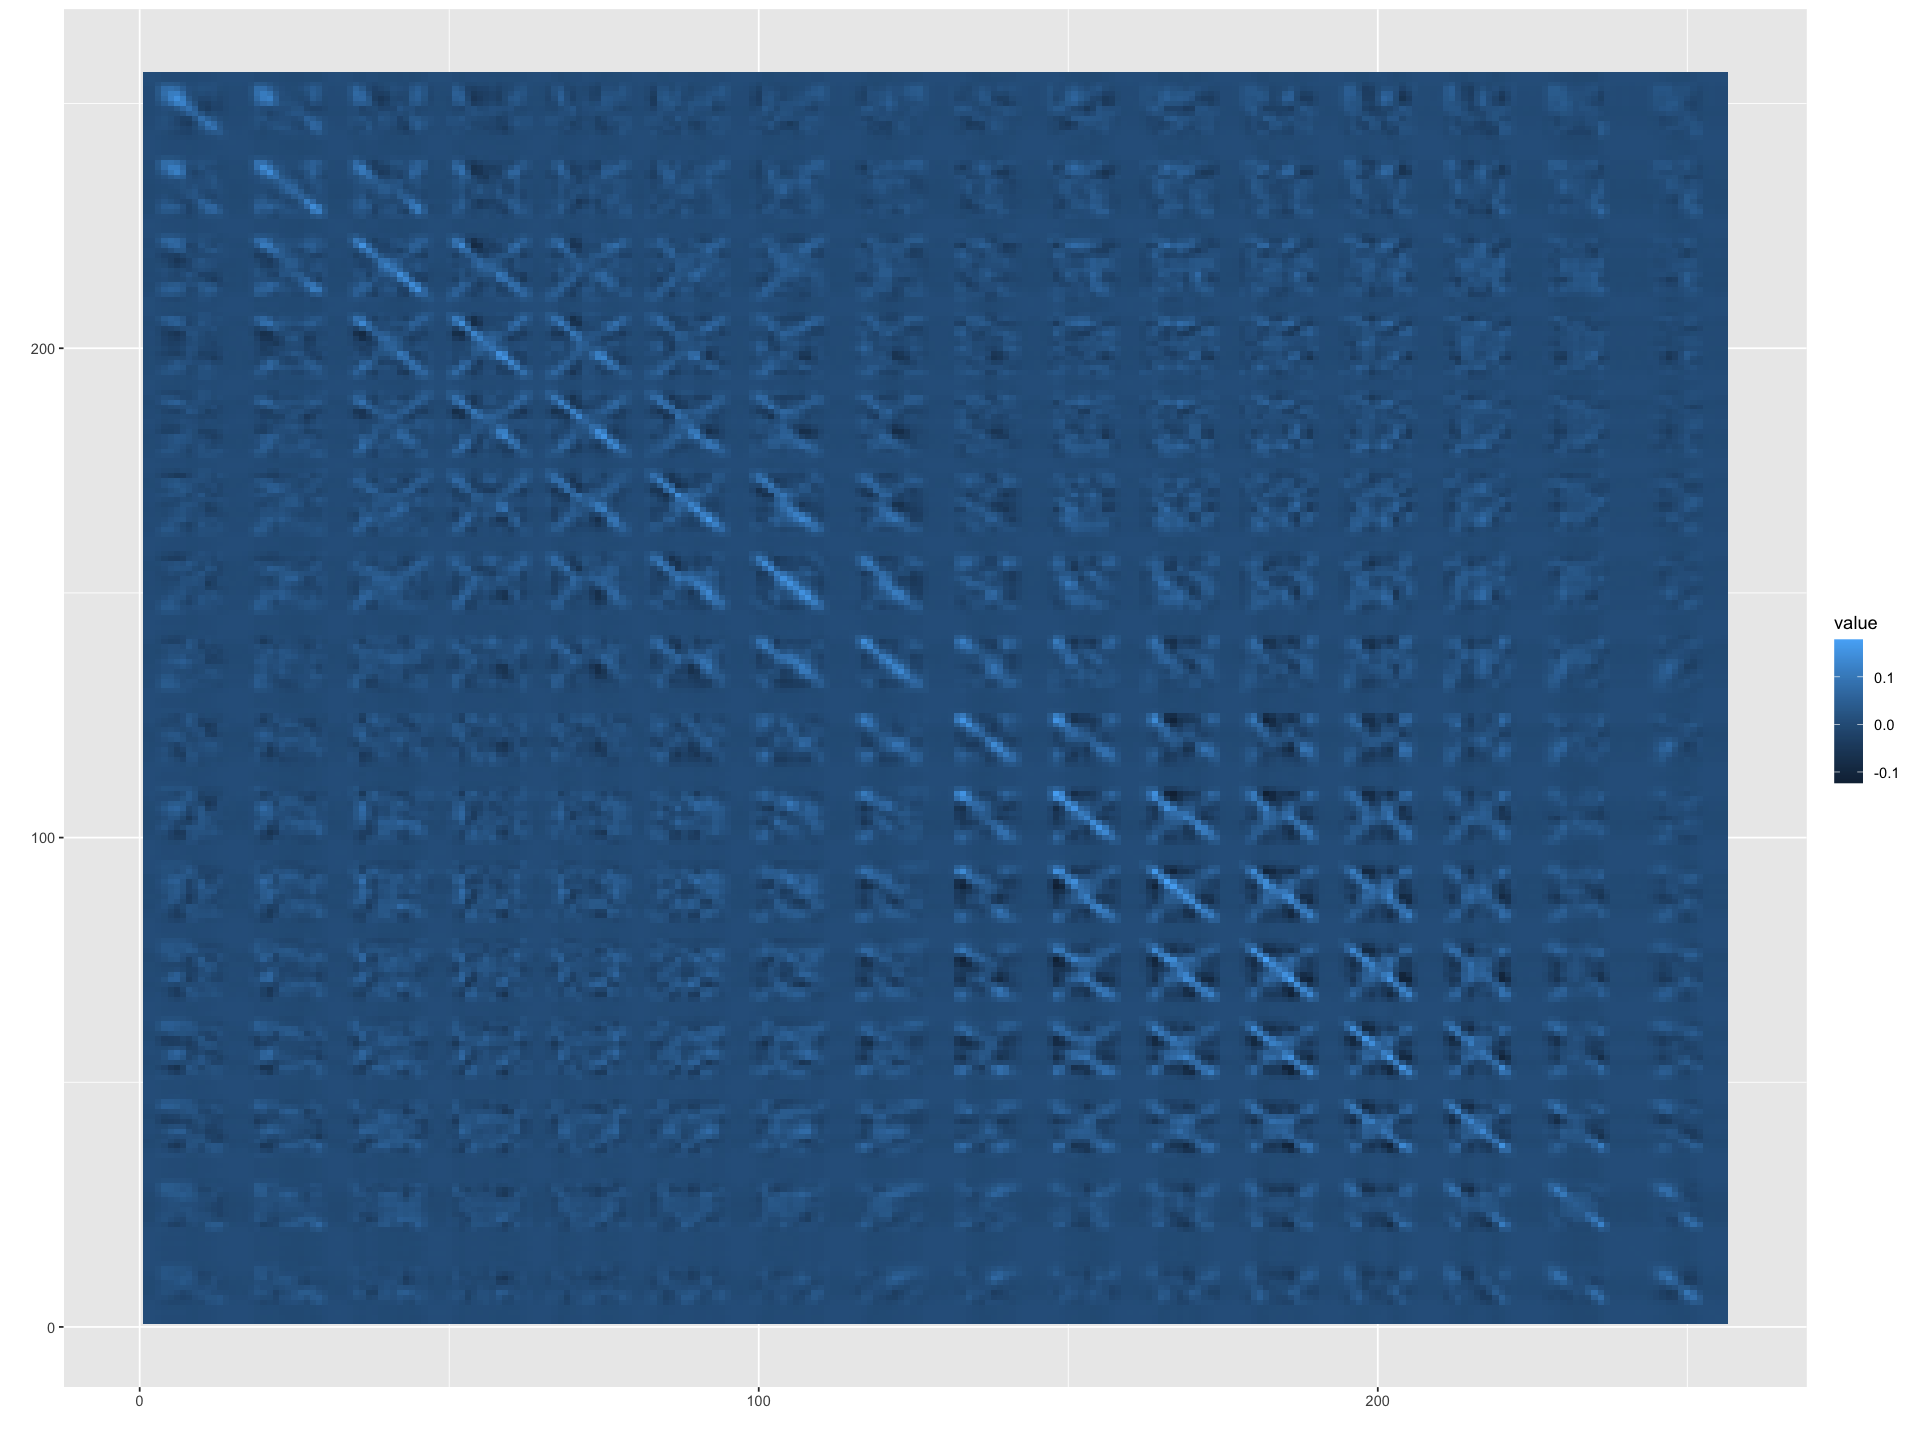

In [280]:
options(repr.plot.width = 16, repr.plot.height = 12)

ggplotdf <- zip2df(matrix(solve(matrix(y_mvn_pred_matrix_eights[row_number, 257:65792], nrow = 256)), nrow=1), 1, FALSE)

plot <- ggplot(data = ggplotdf, aes(x = row, y = col, fill = value)) +
        geom_tile() + xlab("") + ylab("")
plot

Things we haven't done:

1. Checked MCMC output for convergence.
2. Looked at posterior samples for the mean for interpretation. 
3. Incorporated prior information into the distribution of the covariance matrix: ideally we'd like to include the prior information that pixels that are close to each other are highly correlated and those that are far away are not. 
4. Checked for posterior sensitivity to the prior and number of data.